# World Data League 2022

## 🎯 Challenge
Optimization of soft-mobility drop-off points


## Team: Shiny Pandas
## 👥 Authors
* Zsolt Kegyes-Brassai
* Imre Boda
* Peter Michaletzky

## 💻 Development
### Table of Contents
* [1.Summary](#1.-Summary)
* [2. EDA](#2.-EDA)
* [3. Preparations for the optimization](#3.-Preparations-for-the-optimization)
* [4. The optimization](#4.-The-optimization)

### 1. Summary 
1st of June, 2020, most likely close to the end of the first wave of Covid-19 pandemic, Porto launched the E-scooter service. [Electric Scooters in Porto](https://www.porto.pt/en/news/electric-scooters-are-set-to-go-and-ride-through-porto-starting-1st-june)
The idea is to help people to take the last mile faster, so they are more willing to choose public transportation, instead of using their cars in order to avoig having to walk. (While we know walking is healthy....) The problem of abandoned e-scooters on sidewalks, bike lanes, roads, parks is well known everwhere. Penalizing users for not dropping their e-scooters off at the designated parkings is one side of the solution. At the same time the city feels the responsibility for placing these parkings at the most convenient locations, given a few constraints: a maximum of 210 parkings in total, never closer than 40 meters, each having a capacity of Nx10 places.
<figure> <img src="https://www.porto.pt/_next/image?url=https%3A%2F%2Fmedia.porto.pt%2Foriginal_images%2Fmno_pontos_partilha_com_trotinetes_01.JPG&w=1460&q=85" alt=".." width="400">
</figure>

In our analysis we came up with an optimization methodology that helps proposing new parking locations, ultimately decreasing our cost by as much as 27%, where cost represents distance of abandoned e-scooter to nearest parking. In practice this means more e-scooters in designated parkings.
Geospatial distance calculations can become very inefficient on large volumes of data we need to handle in this challenge, hence our decision to apply the H3 grid system approach, which aggregates geospatial information into hexagonal areas (with 25 meters edge length in our case). Distance is measured in terms of "number of crossed hexagon edges".

Our optimization generates a dashboard, that provides hints on approximately where to build new parkings, and where to remove existing ones. These proposals require an expert's review, since many circumstances are unknown to us (constraints by local regulations, practicalities,etc.).

Note: our analysis is data-driven, meaning we can only deal with existing e-scooter traffic. The policital intentions of the operator for starting to cover new areas (no data yet), or placing parkings near major public transportation hubs (well, or minor ones) for advertising purposes were not taken into account in our model yet, but there is room for such adjustments.

Our optimization algorithm was tuned for this specific dataset we received; making it generally applicable for new datasets would require further development efforts.



### 2. EDA
Exploratory data analysis provides insights into all our source data, highlighting key features that matter for this modelling exercise. The following sources were analyzed:
* E-scooter parking locations (See: [2.1 E-scooter parks overview](#2.1-E-scooter-parks-overview))
* E-scooter traffic records (See: [2.2 E-scooter traffic data](#2.2-E-scooter-traffic-data)

We were given Public transportation data as well (bus/metro/tram stations, schedules, lines), and we also did a thorough analysis of these, but we did not use this data source in our modelling, therefore we believe including EDA of public transportation would not add any value to this notebook.

> Technical note: Basic data for this challenge was provided in a zip file. We extracted the content of this file in a folder called "data". Before running this notebook, one would have to follow this method, so the scripts in this file can access those same datafiles.

[Here you can fast forward to the Conclusions of the EDA.](#2.3-Conclusions)

All geographic data is related to Porto city; we start with importing the raw polygon, representing the city borders.
We use OpenStreetMap's public and free data.
Jump to [A1. Porto border polygon](#A1.-Porto-border-polygon) to see how this polygon looks like.

Let's start coding with loading libraries and adding a function for placing titles on Leaflet maps.

In [1]:
library(tidyverse)
library(lubridate)
library(gt)
library(sf)
library(h3jsr)
library(basemaps)
library(leaflet)
library(geojsonio)
library(htmlwidgets)
library(htmltools)

#setting H3 resolution - edge = 25 m, hex to hex center distance = 43 m:
res=11

addTitle <- function(x, title, size){

  tag.map.title <- tags$style(HTML(paste0("
    .leaflet-control.map-title { 
      transform: translate(-50%,20%);
      position: fixed !important;
      left: 50%;
      text-align: center;
      padding-left: 10px; 
      padding-right: 10px; 
      background: rgba(255,255,255,0.50);
      font-weight: bold;
      font-size: ", size, ";
    }
  ")))
  
  title <- tags$div(
    tag.map.title, HTML(title)
  )  
  
  x |> addControl(title, position = "topleft", className="map-title")
}

-- Attaching packages ---------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"package 'stringr' was built under R version 4.1.3"
-- Conflicts ------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'gt' was built under R version 4.1.3"
Warning message:
"package 'sf' was built under R version 4.1.3"
Linking to GEOS 3.9.1, GDAL 3.2.1, PROJ 7.2.1; sf_use_s2() is TRUE

Warning message:
"package 'h

In [2]:
# fetch from osmdata and store the bounding polygon for Porto
 
poly_porto <- osmdata::getbb(place_name = "porto portugal", format_out = "polygon")
sf_poly_porto <- st_sf((st_sfc(st_polygon(poly_porto[1]), crs = 4326)))
#sf_poly_porto |> write_rds(here::here("data/intermediate", "poly_porto.rds"))

#poly_porto <- read_rds(here::here("data/intermediate", "poly_porto.rds"))
poly_porto_mercator <- st_transform(sf_poly_porto, crs = st_crs(3857))

#### 2.1 E-scooter parks overview

##### 2.1.1 Locations, total number, storage capacity

We were given the GPS locations of the official e-scooter parking spots. They can have the capacity of n x 10 e-scooters.

In [3]:
library(repr)
options(repr.plot.width=15, repr.plot.height=9, repr.plot.pointsize=14)

Warning message:
"package 'repr' was built under R version 4.1.3"


E-scooter parking spot info is loaded from the e-scooter_parks.json file of the unzipped dataset. Since dealing with fine-detailed latitude/longitude coordinates make calculations quite lengthy and complicated, we introduced the use of Uber's H3 Library, what makes geospatial calculations lightning fast by aggregating geospatial information into hexagonal areas. Trade-off comes from the inaccuracy of representing an exact location with its hexagonal approximation, a much larger area, the size of which depends on the preset hexagonal resolution. We went for resolution 11, which gives a hexagon diameter of about 40 meters - the minimum distance that has to separate the nearest e-scooter parking spots.

More details about H3 are provided in chapter [3. Preparations for the optimization](3.-Preparations-for-the-optimization)

In [4]:
scooter_parks <- 
  read_sf(here::here("data/E-Scooter Parks", "e-scooter_parks.json")) |> 
  select(park_id = n_id, park = toponimo, status = estado, capacity = n_lugares) |> 
  mutate(idx = row_number(),
         label = glue::glue("[{park_id}] {park}"))

#conversion of lat/lon coordinates to H3 hexagonal codes (indicated by hex numbers)
scooter_parks <- scooter_parks |> 
  mutate(hex = point_to_h3(scooter_parks, res = res))

ggplot() +
  basemap_gglayer(poly_porto_mercator, alpha = 0.7) + 
  geom_sf(data = poly_porto_mercator, alpha = 0, color = "lightslategray", size = 1, linetype = "dashed") +
  geom_sf(data = st_transform(scooter_parks, crs = st_crs(3857)),
          shape = 19, size = 2, color = "darkgreen") +
  coord_sf() +
  scale_fill_identity() +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0, 0)) + 
  theme_bw() +
  theme(plot.title.position = "plot",
        plot.title=element_text(size=26),
        axis.title = element_blank(),
       ) +
  labs(title = "E-scooter parking spots in Porto")


Loading basemap 'terrain' from map service 'osm_stamen'...
  |==================================================| 100% elapsed=02s  


Total number of E-scooter parking spots in our dataset:

In [5]:
scooter_parks |> nrow()

[1] 216

So here we hit the limitation given in the challenged description, that we can have 210 spots only.

From size (capacity) perspective, parking spots can have n x 10 places for storing e-scooters. Most of them have 10 places, except for the following sites with double capacity:

In [6]:
n20 <- scooter_parks |> as_tibble() |> filter(capacity > 10) |> arrange(park_id)
n20

park_id park                                     status capacity
1  10     Rua D. Frei Vicente da Soledade e Castro ATIVO  20      
2  19     Rua do Dr. Plácido da Costa              ATIVO  20      
3  38     RESTA0                                   ATIVO  20      
4 128     RCAMO0                                   ATIVO  20      
  geometry                   idx label                                        
1 POINT (-8.597936 41.1776)    9 [10] Rua D. Frei Vicente da Soledade e Castro
2 POINT (-8.600135 41.17884)  17 [19] Rua do Dr. Plácido da Costa             
3 POINT (-8.586115 41.14817)  35 [38] RESTA0                                  
4 POINT (-8.609936 41.15232) 125 [128] RCAMO0                                 
  hex            
1 8b39220e2c01fff
2 8b39220e2d19fff
3 8b39220f1661fff
4 8b39220f1cb6fff

#### 2.1.2 Parking spots too close to each other
In accordance with the challenge description, parking spots must not be located closer than 40 meters to each other. Let's find out if there are cases that do not respect this rule.

In [7]:
idx = seq(1, nrow(scooter_parks))

# first the distance in meters is calculated by running a pair-wise distance calculation:
park_distance <- 
  st_distance(
    scooter_parks, 
    scooter_parks,
    by_element = FALSE
    ) |> 
  as_tibble() |> 
  rename_with(~ idx, everything()) |> 
  mutate(idx1 = idx) |> 
  pivot_longer(
    -idx1,
    names_to = "idx2",
    values_to = "distance"
    ) |> 
  mutate(distance = units::drop_units(distance)) |> 
  filter(distance > 0) |> 
  arrange(distance, idx1) |> 
  mutate(idx2 = as.integer(idx2))

# then the hexagonal distance is also calculated (number of hex boundaries crossed when going from A to B)
park_distance <- park_distance |> 
  left_join(scooter_parks |> as_tibble() |> select(idx, hex), by = c("idx1" = "idx")) |> 
  left_join(scooter_parks |> as_tibble() |> select(idx, hex), by = c("idx2" = "idx")) |> 
  mutate(hex_distance = grid_distance(hex.x, hex.y)) |> 
  select(-starts_with("hex."))

print("The distance between pairs of parking spots, too close to each other. (examples above 40m are also included) The `hex_distance` refers to the distance on the hex grids.")
park_distance |> 
  distinct(distance, .keep_all = TRUE) |> 
  head(12) |> 
  left_join(scooter_parks |> as_tibble() |> select(idx, label),
            by = c("idx1" = "idx")) |> 
  left_join(scooter_parks |> as_tibble() |> select(idx, label),
            by = c("idx2" = "idx"),
            suffix = c("_1", "_2")) |> 
  select(starts_with("label"), distance, hex_distance) 

[1] "The distance between pairs of parking spots, too close to each other. (examples above 40m are also included) The `hex_distance` refers to the distance on the hex grids."


label_1                   label_2                     distance  hex_distance
1  [119] RTVAL1              [120] RTVAL1                 3.033908 0           
2  [92] ABOAV0               [93] ABOAV0                 20.316392 0           
3  [103] AMGCO0              [104] AMGCO0                27.559687 0           
4  [152] RCAMO0              [153] RSBRA0                31.969352 1           
5  [211] RHSRE0              [212] RHSRE0                34.591861 0           
6  [161] RGCRI0              [162] RGCRI0                40.836139 0           
7  [26] Rua do Molhe         [27] Avenida do Brasil      45.398193 1           
8  [94] ABOAV0               [95] RJGRA0                 46.752554 1           
9  [197] ACXAN0              [198] ACONG0                48.642741 1           
10 [80] Praça do Bom Sucesso [82] Rua de Gonçalo Sampaio 48.813381 1           
11 [155] RACAB0              [156] RCEDO0                52.536204 1           
12 [112] AFRAN0              [122] RPJAS0                52.770246 2

In [8]:
# Parkings too close to each other:
close_parks <- park_distance |> filter(distance < 40) |> distinct(idx1) |> pull(idx1)
close_hex <- scooter_parks |> as_tibble() |> count(hex, sort = TRUE) |> filter(n > 1) |> pull(hex)

scooter_parks <- scooter_parks |> 
  mutate(close_distance = idx %in% close_parks,
         close_hex = hex %in% close_hex)

In [9]:
scooter_parks_close <- scooter_parks |> filter(close_distance | close_hex) 

poly_parks_close <- scooter_parks_close |> as_tibble() |> count(hex) |> h3_to_polygon(simple = FALSE) 

leaflet() |> 
  addTiles(options = tileOptions(opacity = 0.5)) |> 

  addPolygons(data = poly_parks_close,
              color = "red", weight = 2,
              fillColor = "red", fillOpacity = 0.1,
              label = ~ h3_address) |> 
  
  addCircles(data = scooter_parks_close,
             color = "navy", weight = 6, radius = 1, 
             label = ~ label) |>
             saveWidget(here::here("submit", "leaflet_parks_too_close.html"))

**Parking spots too close to each other**

[Leaflet viewer of parkings too close to each other](http://peter.michaletzky.gitlab.io/dataproj_public/leaflet_parks_too_close.html)

RSBRA0 and RCAMO0 stations are only 27.5 meters apart.

#### 2.2 E-scooter traffic data
##### 2.2.1 Loading the data and analyzing the timespan.

In [10]:
wdl_od <- 
  read_csv(here::here("data/E-Scooter OD", "wdl_od_view.csv")) |> 
  mutate(across(c(recorded, timestamp, telemetry_timestamp), ~ lubridate::as_datetime(.x/1e3))) |> 
  # order: x = lng, y = lat
  select(-lat, everything())

skim_wdl_od <- skimr::skim(wdl_od)

skim_wdl_od |>  
  filter(skim_type == "POSIXct") |> 
  select(variable = skim_variable, min = POSIXct.min, max = POSIXct.max)

Rows: 489279 Columns: 11
-- Column specification ---------------------------------------------------------------------------------------------------------------------------------------------------------
Delimiter: ","
chr (5): device_id, event_types, vehicle_state, trip_state, trip_id
dbl (6): recorded, id, timestamp, telemetry_timestamp, lat, lng

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


A skim_df: 3 × 3 
 
 variable min max 
 <chr> <dttm> <dttm> 
 
 
 recorded 2021-10-21 09:38:35 2022-03-09 12:04:47 
 timestamp 2021-10-20 12:48:03 2022-03-09 12:04:46 
 telemetry_timestamp 2021-07-08 09:40:06 2022-03-09 12:03:14

# A tibble: 3 x 3
  variable            min                 max                
  <chr>               <dttm>              <dttm>             
1 recorded            2021-10-21 09:38:35 2022-03-09 12:04:47
2 timestamp           2021-10-20 12:48:03 2022-03-09 12:04:46
3 telemetry_timestamp 2021-07-08 09:40:06 2022-03-09 12:03:14


A relative **short time period** (around 4 months) is covered by the data.

The data is not supporting our initial idea to analyse multiple scenarios, like tourist season and off-season.

In [11]:
skim_wdl_od |>  
  filter(skim_type == "character") |> 
  select(variable = skim_variable, count_unique = character.n_unique) |> 
  filter(count_unique > 1000) 

A skim_df: 2 × 2 
 
 variable count_unique 
 <chr> <int> 
 
 
 device_id 3720 
 trip_id 79874

# A tibble: 2 x 2
  variable  count_unique
  <chr>            <int>
1 device_id         3720
2 trip_id          79874


A fairly large number of scooters (devices) and trips are included in the data.

##### 2.2.2 E-scooter trip-related data

There is no direct information in the logs about whether a scooter is dropped-off exactly in a parking, as you will see this in the dataset.

In [12]:
wdl_od |> 
  filter(str_detect(event_types, "trip")) |> 
  count(vehicle_state, event_types, name = "count") |> 
  arrange(vehicle_state, count) 
  # janitor::clean_names(sep_out = " ") |> 
 

vehicle_state   event_types                    count
1  available       {trip_cancel}                   5967
2  available       {trip_end}                     65091
3  elsewhere       {trip_leave_jurisdiction}      16369
4  non_operational {trip_cancel,battery_low}         15
5  non_operational {trip_end,battery_low}          2314
6  on_trip         {provider_drop_off,trip_start}     3
7  on_trip         {battery_charged,trip_start}      37
8  on_trip         {located,trip_start}             597
9  on_trip         {trip_enter_jurisdiction}      17072
10 on_trip         {trip_start}                   71909
11 removed         {trip_cancel,decommissioned}       1
12 removed         {trip_end,decommissioned}          2
13 unknown         {trip_end,comms_lost}              9
14 unknown         {trip_cancel,comms_lost}          16
15 unknown         {trip_cancel,missing}             16
16 unknown         {trip_end,missing}                31

\
Let's focus on the following items, as they seem to describe traffic related activities: `available` and `on_trip` vehicle_states, with the eception of `on_trip - {trip_enter_jurisdiction}` event_type. We create a scooter trip table containing both the start and end points.
Here is a short extract:


In [13]:
wdk_start_end <- 
  wdl_od |>
  filter(str_detect(event_types, "trip"),
         vehicle_state %in% c("available", "on_trip"),
         !str_detect(event_types, "jurisdiction")) |>
  select(device_id, trip_id, event_types, vehicle_state, telemetry_timestamp, lng, lat)

wdk_start <- 
  wdk_start_end |> 
  filter(str_detect(event_types, "start")) |> 
  arrange(device_id, trip_id, telemetry_timestamp) |> 
  distinct(device_id, trip_id, .keep_all = TRUE)


wdk_end <- 
  wdk_start_end |> 
  filter(!str_detect(event_types, "start")) |> 
  arrange(device_id, trip_id, desc(telemetry_timestamp)) |> 
  distinct(device_id, trip_id, .keep_all = TRUE)


trip_start_stop <- 
  full_join(
    wdk_start |> semi_join(wdk_end, by = c("device_id", "trip_id")),
    wdk_end |> semi_join(wdk_start, by = c("device_id", "trip_id")),
    by = c("device_id", "trip_id"),
    suffix = c("_start", "_end")
  ) |> 
  arrange(telemetry_timestamp_start)

trip_start_stop |> 
  select(-ends_with("_id")) |> 
  head(12) 

event_types_start    vehicle_state_start telemetry_timestamp_start lng_start
1  {located,trip_start} on_trip             2021-10-25 21:57:43       -8.630352
2  {trip_start}         on_trip             2021-10-26 21:07:55       -8.612310
3  {trip_start}         on_trip             2021-10-26 21:09:15       -8.665110
4  {trip_start}         on_trip             2021-10-26 21:14:00       -8.610342
5  {trip_start}         on_trip             2021-10-26 21:14:18       -8.617040
6  {trip_start}         on_trip             2021-10-26 21:14:37       -8.609820
7  {trip_start}         on_trip             2021-10-26 21:16:53       -8.612592
8  {trip_start}         on_trip             2021-10-26 21:22:31       -8.672183
9  {trip_start}         on_trip             2021-10-26 21:23:36       -8.605543
10 {trip_start}         on_trip             2021-10-26 21:32:39       -8.610805
11 {trip_start}         on_trip             2021-10-26 21:34:23       -8.609190
12 {trip_start}         on_trip             2021-10-26 21:34:37       -8.609218
   lat_start event_types_end vehicle_state_end telemetry_timestamp_end
1  41.15754  {trip_end}      available         2021-10-25 21:57:43    
2  41.14512  {trip_end}      available         2021-10-26 21:29:52    
3  41.14802  {trip_end}      available         2021-10-26 21:17:34    
4  41.17300  {trip_cancel}   available         2021-10-26 21:14:23    
5  41.14079  {trip_end}      available         2021-10-26 21:32:26    
6  41.17453  {trip_end}      available         2021-10-26 21:17:04    
7  41.17109  {trip_end}      available         2021-10-26 21:24:24    
8  41.16576  {trip_end}      available         2021-10-26 21:49:47    
9  41.15358  {trip_end}      available         2021-10-26 21:33:08    
10 41.14368  {trip_end}      available         2021-10-26 23:02:37    
11 41.17797  {trip_end}      available         2021-10-26 21:47:12    
12 41.17804  {trip_end}      available         2021-10-26 21:47:20    
   lng_end   lat_end 
1  -8.630352 41.15754
2  -8.607330 41.14612
3  -8.660725 41.14732
4  -8.610248 41.17401
5  -8.665128 41.14802
6  -8.609185 41.17795
7  -8.603720 41.16173
8  -8.683348 41.15905
9  -8.609858 41.16036
10 -8.612543 41.14046
11 -8.600007 41.17881
12 -8.600065 41.17882

We can also link trips to parkings

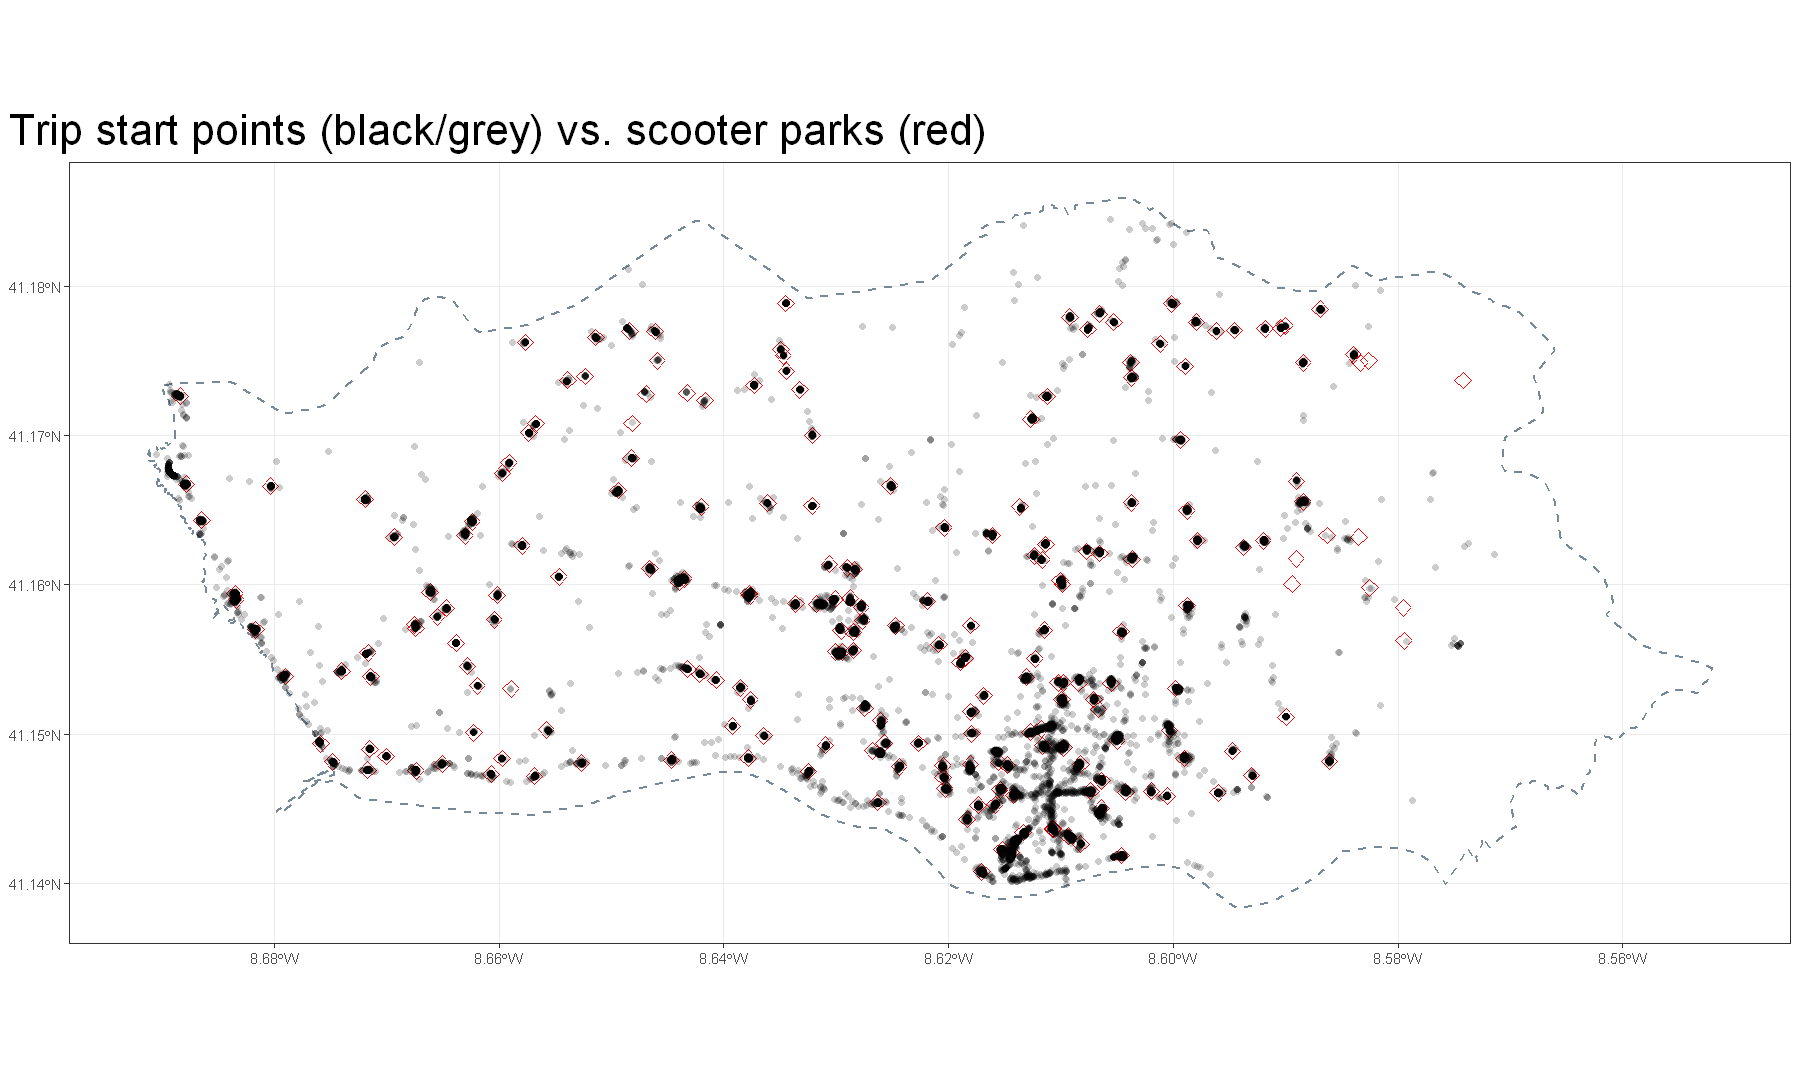

In [14]:
trip_start_stop |> 
  # head(100) |>
  st_as_sf(coords = c("lng_start", "lat_start"), crs = 4326) |> 
  ggplot() +
  geom_sf(data = poly_porto_mercator, alpha = 0, color = "lightslategray", linetype = "dashed", size = 0.7) +
  geom_sf(data = scooter_parks, alpha = 1, color = "red", shape = 5, size = 3) +
  geom_sf(alpha = 0.2, shape = 16) +
  theme_bw() +
  theme(plot.title.position = "plot",
       plot.title=element_text(size=26)) +
  labs(title = "Trip start points (black/grey) vs. scooter parks (red)")

In [15]:
trip_start_stop |> 
  # head(100) |> 
  st_as_sf(coords = c("lng_end", "lat_end"), crs = 4326) |> 
  ggplot() +
  geom_sf(data = poly_porto_mercator, alpha = 0, color = "lightslategray", linetype = "dashed", size = 0.7) +
  geom_sf(data = scooter_parks, alpha = 1, color = "red", shape = 5, size = 3) +
  geom_sf(alpha = 0.2, shape = 16) +
  theme_bw() +
  theme(plot.title.position = "plot",
       plot.title=element_text(size=26)) +
  labs(title = "Trip end points (back/grey) vs. scooter parks (red)")


It's somewhat visible that more trip starts are closer to the scooter parks than the trip ends (dots outside the red squares), meaning that less scooters are returned to the designated places.

Let's calculate the distance metrics between start and end points, and nearest scooter parks and include the trip durations.\
Here is a short extract:

In [16]:
trip_distance <- trip_start_stop |> 
  mutate(distance_start_end = st_distance(
    trip_start_stop |> st_as_sf(coords = c("lng_start", "lat_start"), crs = 4326),
    trip_start_stop |> st_as_sf(coords = c("lng_end", "lat_end"), crs = 4326),
    by_element = TRUE
    )
  ) |> 
  mutate(distance_start_end = units::drop_units(distance_start_end)) |> 
  
  mutate(distance_park_start = st_distance(
    trip_start_stop |> st_as_sf(coords = c("lng_start", "lat_start"), crs = 4326),
    scooter_parks
    ) |> 
    matrixStats::rowMins()
  ) |> 
  mutate(distance_park_end = st_distance(
    trip_start_stop |> st_as_sf(coords = c("lng_end", "lat_end"), crs = 4326),
    scooter_parks
    ) |> 
    matrixStats::rowMins()
  ) |> 
  
  mutate(duration = time_length(telemetry_timestamp_start %--% telemetry_timestamp_end))

In [17]:
trip_distance |> 
  select(-starts_with("lng"), -starts_with("lat")) |> 
  select(-ends_with("_id")) |> 
  head(12) |> 
  janitor::clean_names(sep_out = " ") 

event types start    vehicle state start telemetry timestamp start
1  {located,trip_start} on_trip             2021-10-25 21:57:43      
2  {trip_start}         on_trip             2021-10-26 21:07:55      
3  {trip_start}         on_trip             2021-10-26 21:09:15      
4  {trip_start}         on_trip             2021-10-26 21:14:00      
5  {trip_start}         on_trip             2021-10-26 21:14:18      
6  {trip_start}         on_trip             2021-10-26 21:14:37      
7  {trip_start}         on_trip             2021-10-26 21:16:53      
8  {trip_start}         on_trip             2021-10-26 21:22:31      
9  {trip_start}         on_trip             2021-10-26 21:23:36      
10 {trip_start}         on_trip             2021-10-26 21:32:39      
11 {trip_start}         on_trip             2021-10-26 21:34:23      
12 {trip_start}         on_trip             2021-10-26 21:34:37      
   event types end vehicle state end telemetry timestamp end distance start end
1  {trip_end}      available         2021-10-25 21:57:43        0.0000         
2  {trip_end}      available         2021-10-26 21:29:52      431.7594         
3  {trip_end}      available         2021-10-26 21:17:34      375.2084         
4  {trip_cancel}   available         2021-10-26 21:14:23      113.1331         
5  {trip_end}      available         2021-10-26 21:32:26     4106.2247         
6  {trip_end}      available         2021-10-26 21:17:04      384.1665         
7  {trip_end}      available         2021-10-26 21:24:24     1278.7170         
8  {trip_end}      available         2021-10-26 21:49:47     1195.9401         
9  {trip_end}      available         2021-10-26 21:33:08      835.8184         
10 {trip_end}      available         2021-10-26 23:02:37      386.8508         
11 {trip_end}      available         2021-10-26 21:47:12      774.2083         
12 {trip_end}      available         2021-10-26 21:47:20      771.0006         
   distance park start distance park end duration
1   93.228014           93.228014           0    
2  182.822839            6.703187        1317    
3    3.071657            1.177961         499    
4   86.064771          175.230203          23    
5    2.160953            4.748813        1088    
6  243.338864            2.026387         147    
7    7.884177            4.734544         451    
8   20.584907            5.310908        1636    
9   19.861546           18.927726         572    
10   7.605588          243.034294        5398    
11   3.149566           11.404933         769    
12   9.941841            6.533665         763

Note: the shortest distance between points (in meters) was calculated because no track was registered for any of these trips

The distribution of the trip distance and duration exhibits a long tail, and considerable ammount of zero or near zero values.

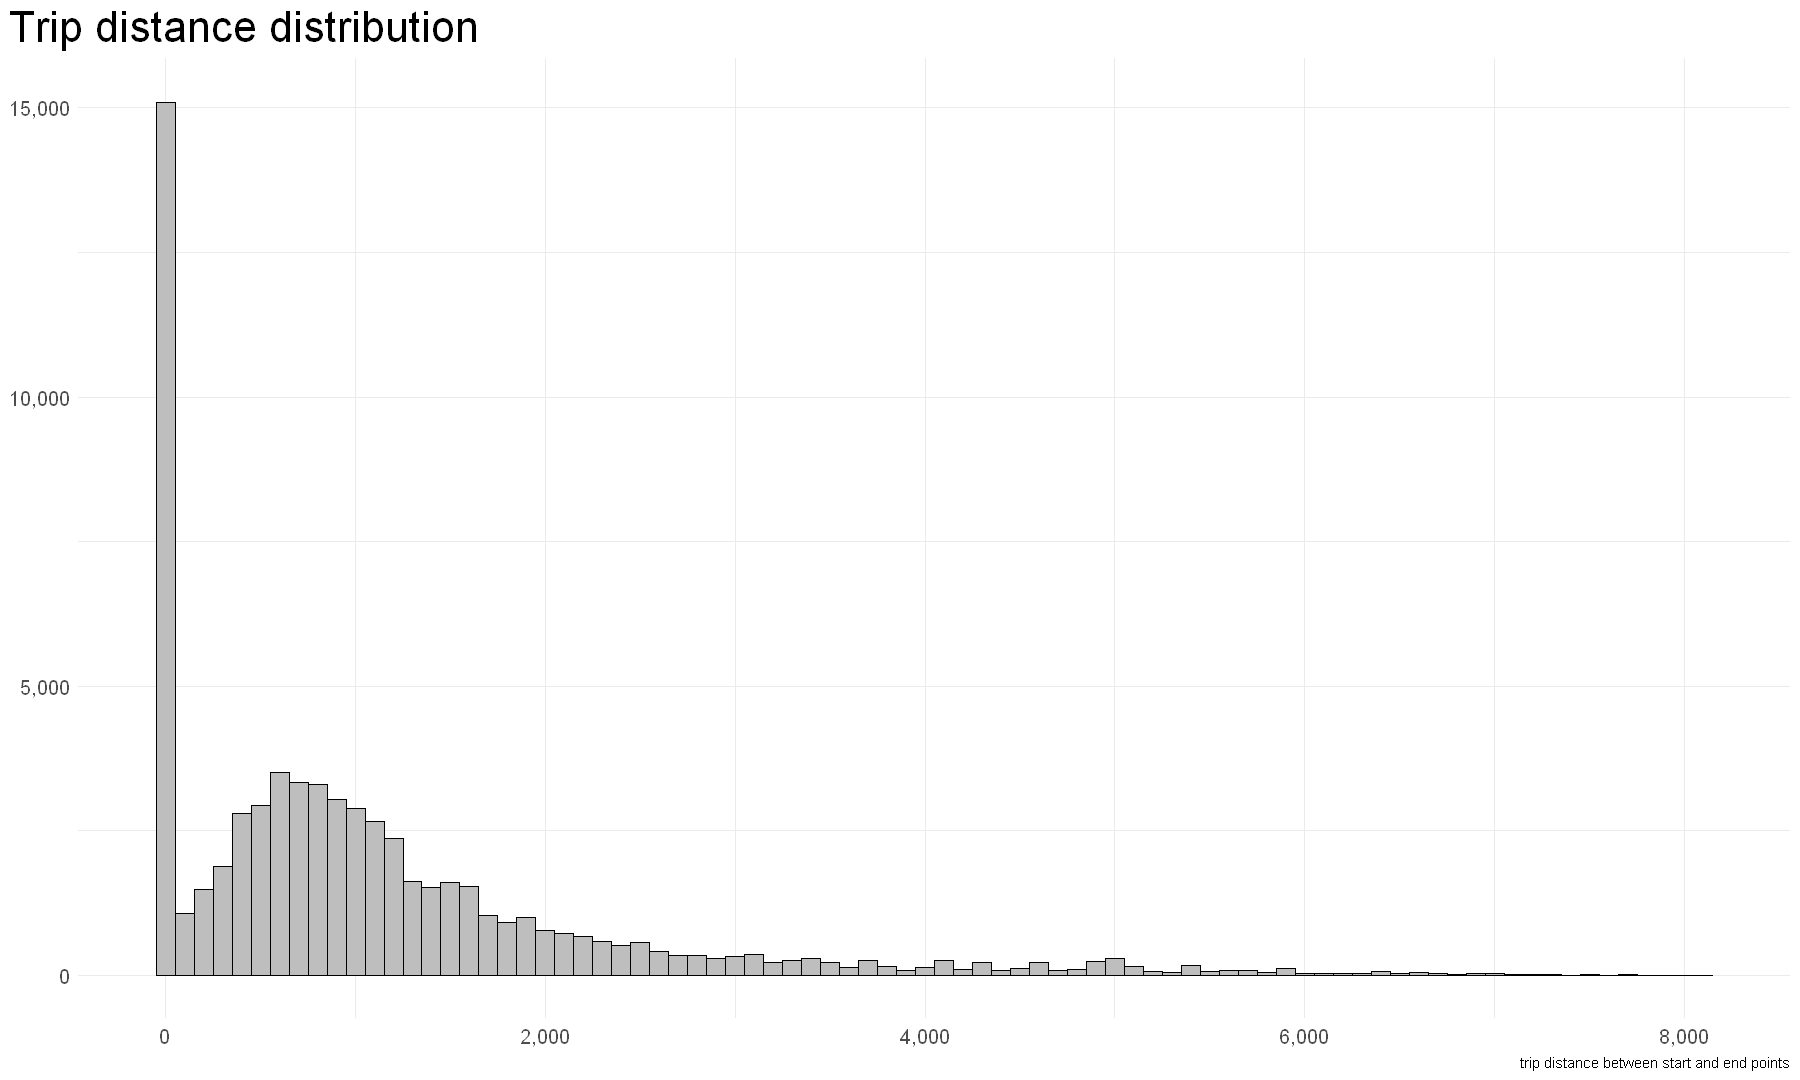

In [18]:
trip_distance |> 
  # filter(distance_start_end > 50) |> 
  ggplot() +
  geom_histogram(aes(distance_start_end), binwidth = 100, center = 100,
                 fill = "gray", color = "black")  +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::comma) +
  theme_minimal() +
  theme(axis.title = element_blank(),
        plot.title.position = "plot",
        axis.text=element_text(size=12),
       plot.title=element_text(size=26)) +
  labs(title = "Trip distance distribution",
       caption = "trip distance between start and end points")


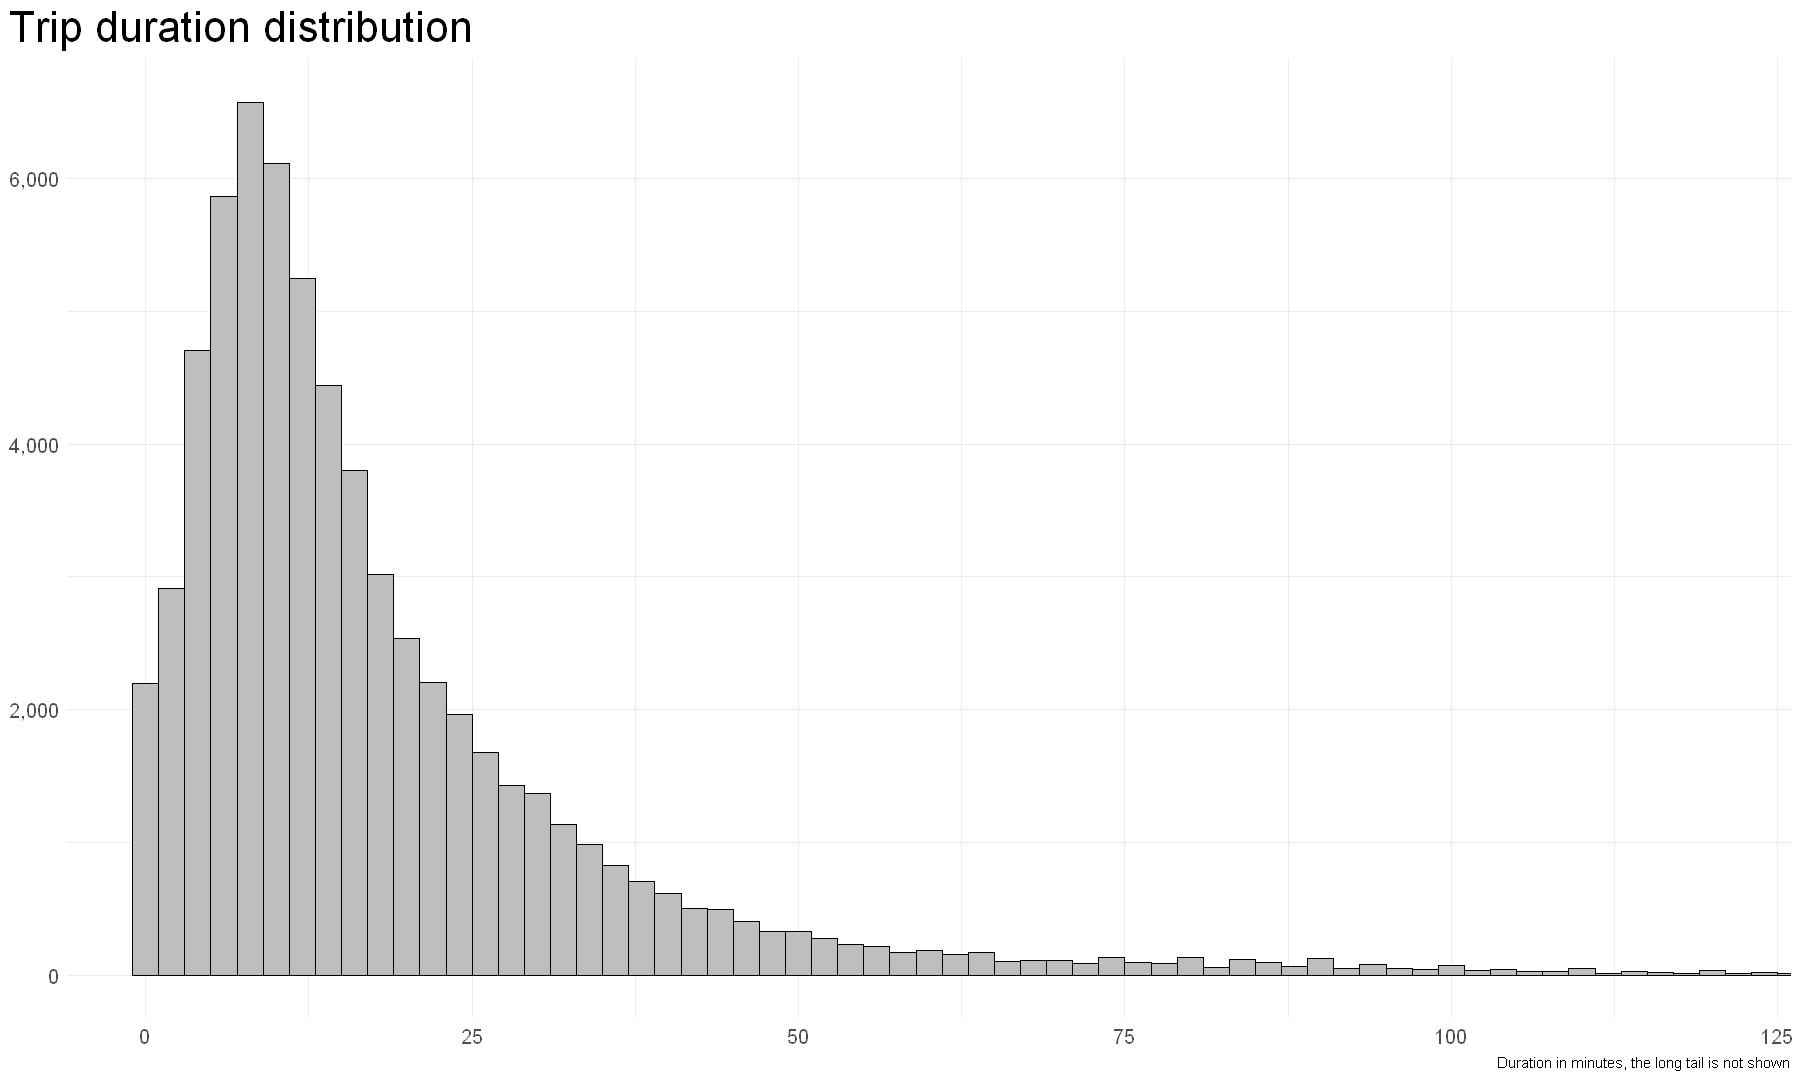

In [19]:
trip_distance |> 
  mutate(duration = duration / 60) |> 
  ggplot() +
  geom_histogram(aes(duration), binwidth = 2, center = 2,
                 fill = "gray", color = "black")  +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::comma) +
  coord_cartesian(xlim = c(0, 120)) +
  theme_minimal() +
  theme(axis.title = element_blank(),
        plot.title.position = "plot",
        axis.text=element_text(size=12),
       plot.title=element_text(size=26)) +
  labs(title = "Trip duration distribution",
       caption = "Duration in minutes, the long tail is not shown")


Registered S3 method overwritten by 'ggforce':
  method           from 
  scale_type.units units



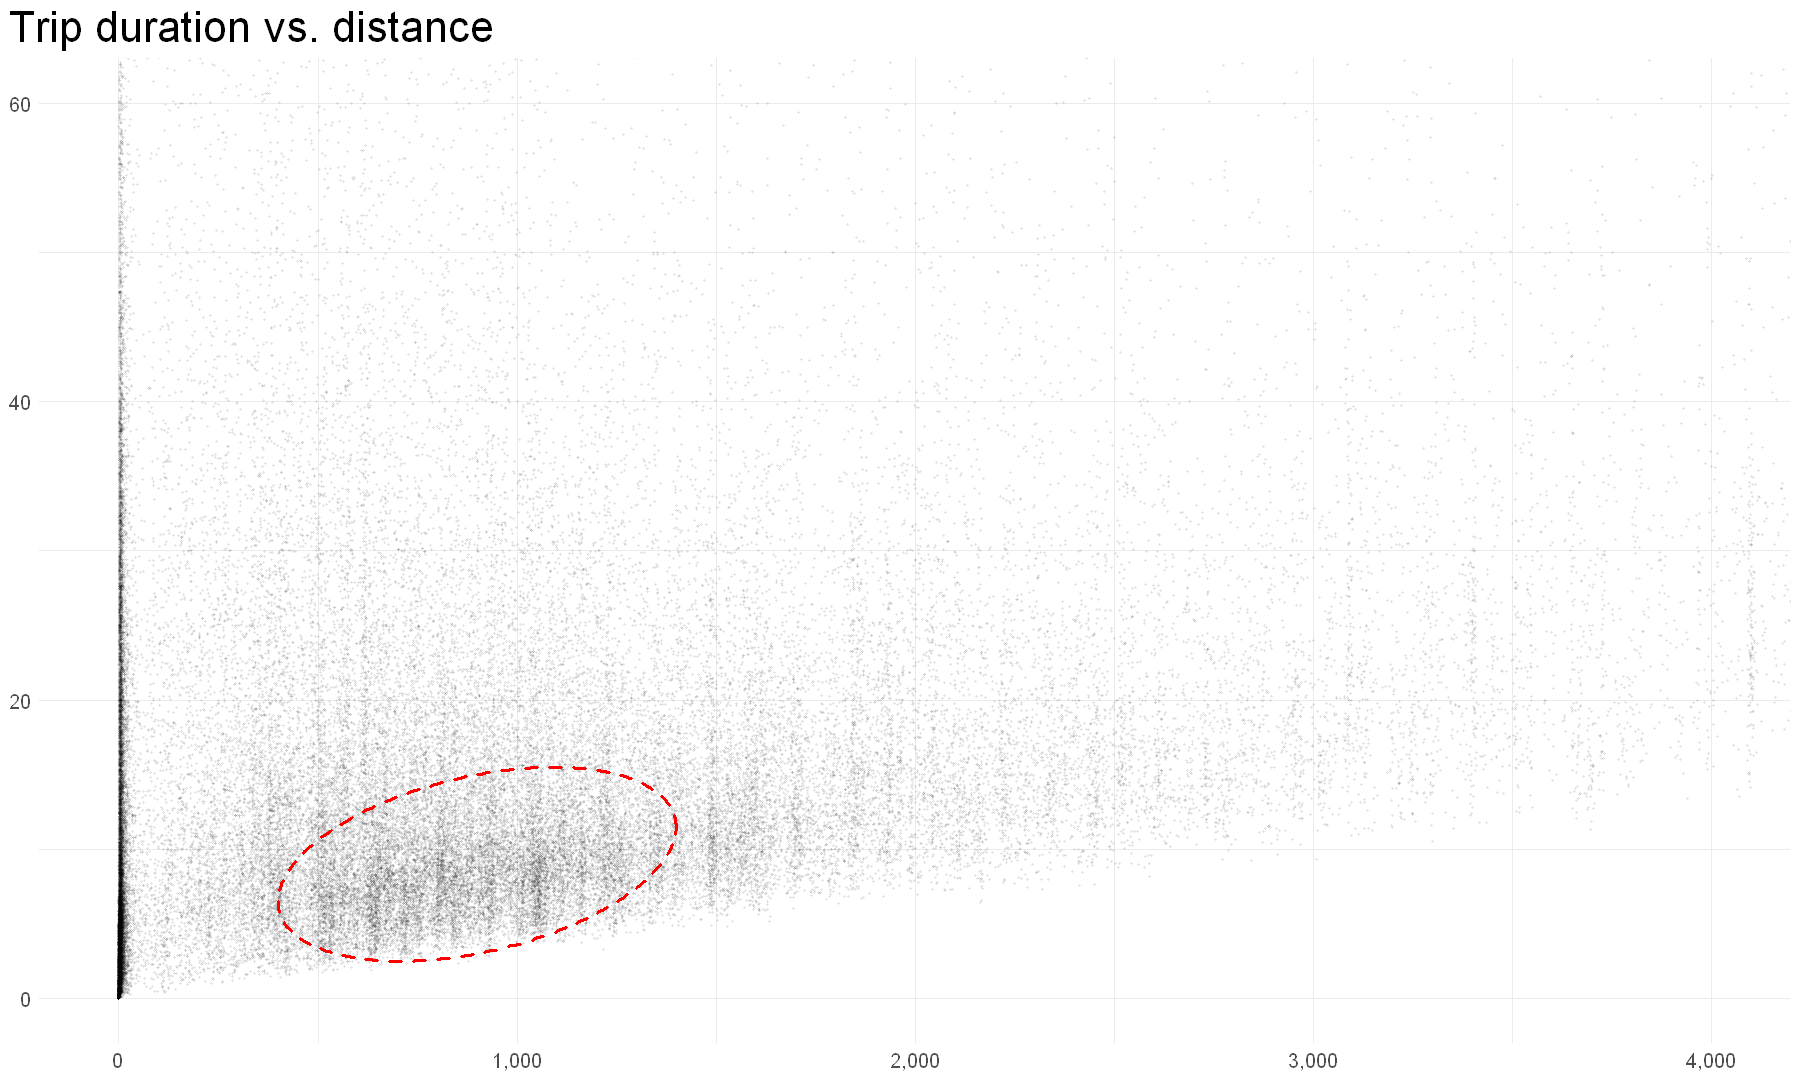

In [20]:
ggplot() +
  geom_point(data = trip_distance |> mutate(duration = duration / 60),
             aes(distance_start_end, duration),
             alpha = 0.1, shape = 16, size = 0.5) +
  ggforce::geom_ellipse(aes(x0 = 900, y0 = 9, a = 500, b = 6, angle = 0.005),
                        size = 1, color = "red", linetype = "dashed") +
  scale_x_continuous(labels = scales::comma) +
  coord_cartesian(xlim = c(0, 4000), ylim = c(0, 60)) +
  theme_minimal() +
  theme(axis.title = element_blank(),
        plot.title.position = "plot",
       axis.text=element_text(size=12),
       plot.title=element_text(size=26)) +
  labs(title = "Trip duration vs. distance")

**The typical trip is between 500 m and 1,5 km and last about 10 minutes.**

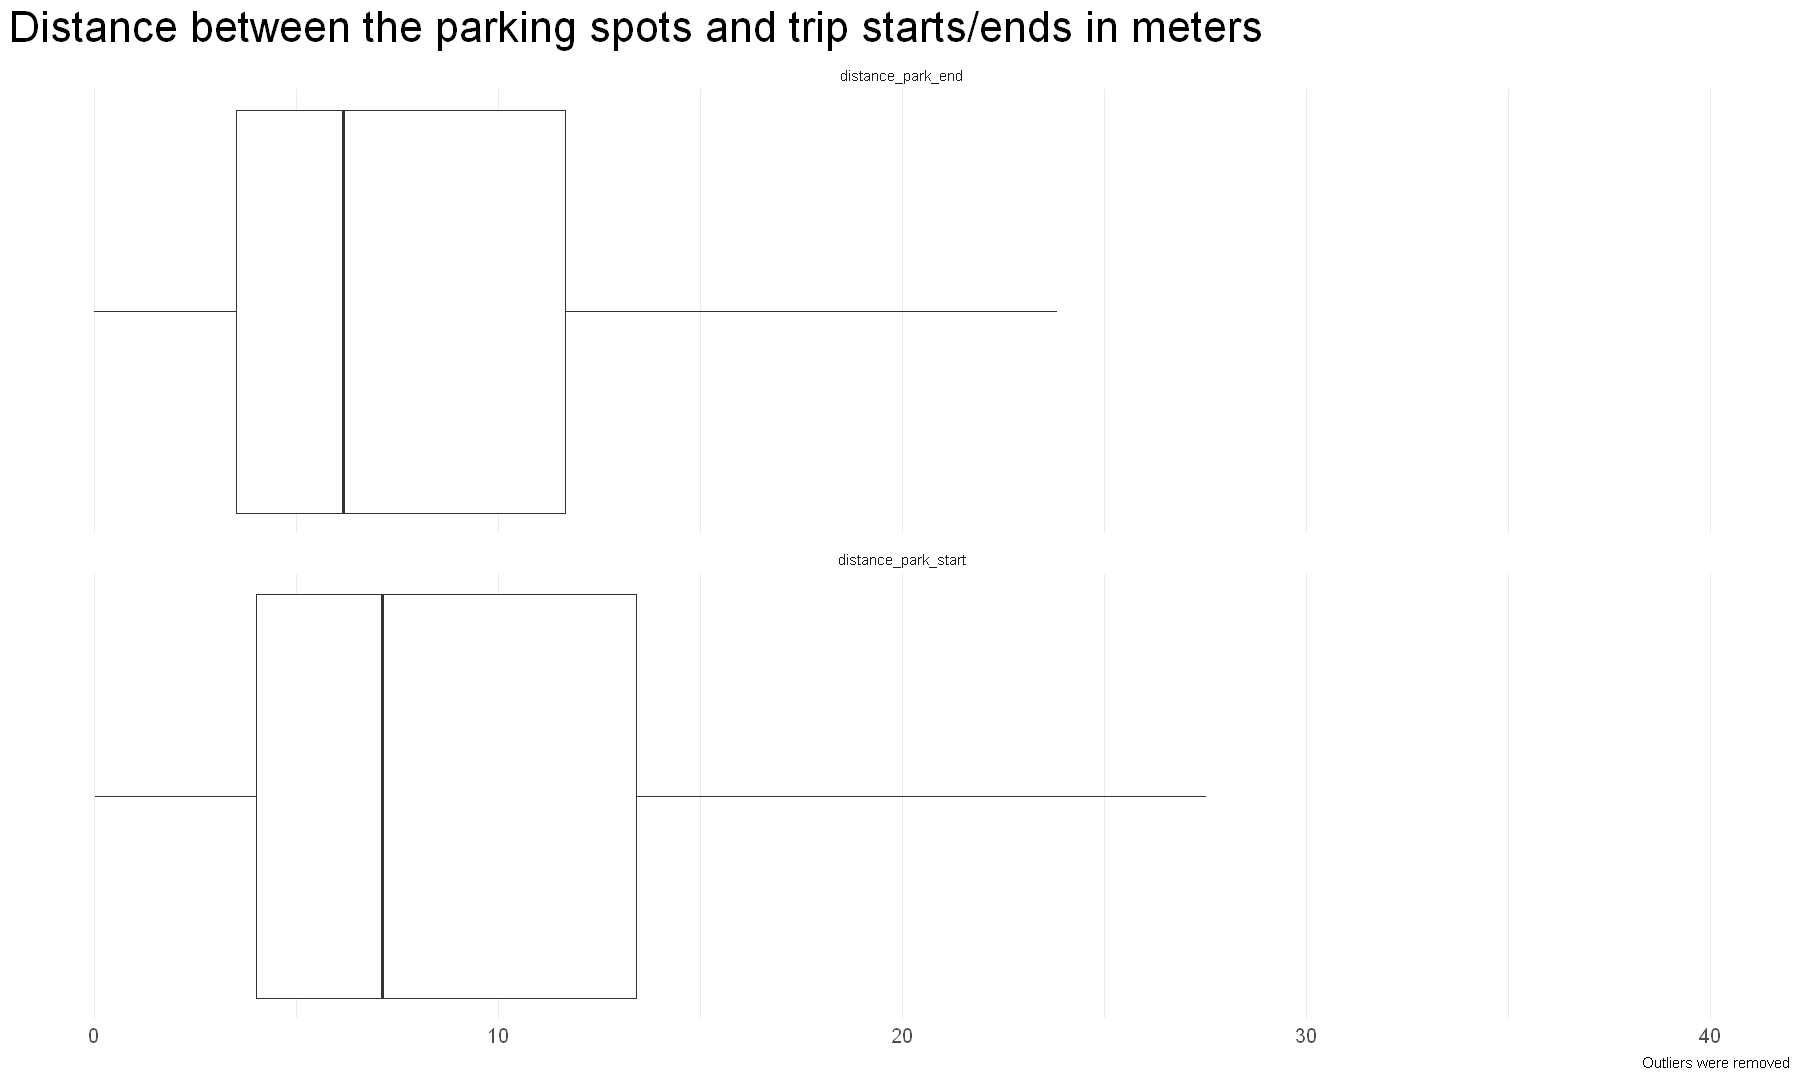

In [21]:
trip_distance |> 
  select(distance_park_start, distance_park_end) |> 
  pivot_longer(
    cols = everything(),
    names_to = "start_end",
    values_to = "distance"
  ) |> 
  ggplot(aes(distance)) +
  geom_boxplot(outlier.color = "lightgray", outlier.alpha = 0.5, outlier.shape = NA) +
  coord_cartesian(xlim = c(0, 40)) +
  facet_wrap(start_end ~ ., ncol = 1) +
  theme_minimal() +
  theme(axis.title = element_blank(),
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        plot.title.position = "plot",
       axis.text=element_text(size=12),
       plot.title=element_text(size=26)) +
  labs(title = "Distance between the parking spots and trip starts/ends in meters",
       caption = "Outliers were removed")


In **majority of cases** (~75%) the scooters were **picked from and returned to the scooter parks** (these distances are less than 10 meters).

Dataset also contains non trip-related data. We moved the summary of this data into the Appendix: [A2. E-scooter traffic data - non trip-related data](#A2.-E-scooter-traffic-data---non-trip-related-data)


##### 2.2.3 Trends

The busiest parking spots with some trip start and end statistics:

In [22]:
trip_start <- 
  trip_start_stop |> 
  st_as_sf(coords = c("lng_start", "lat_start"), crs = 4326) 

trip_end <- 
  trip_start_stop |> 
  st_as_sf(coords = c("lng_end", "lat_end"), crs = 4326) 

park_trip_start <- 
  st_distance(trip_start, scooter_parks) |> 
  as_tibble() |> 
  mutate(trip_idx = row_number()) |> 
  pivot_longer(
    cols = - trip_idx,
    names_to = "idx",
    values_to = "distance"
  ) |> 
  mutate(idx = as.integer(parse_number(idx))) |> 
  mutate(distance = units::drop_units(distance)) |> 
  group_by(trip_idx) |> 
  slice_min(order_by = distance, n = 1) |> 
  ungroup() |> 
  rename(idx_start = idx)

park_trip_end <- 
  st_distance(trip_end, scooter_parks) |> 
  as_tibble() |> 
  mutate(trip_idx = row_number()) |> 
  pivot_longer(
    cols = - trip_idx,
    names_to = "idx",
    values_to = "distance"
  ) |> 
  mutate(idx = as.integer(parse_number(idx))) |> 
  mutate(distance = units::drop_units(distance)) |> 
  group_by(trip_idx) |> 
  slice_min(order_by = distance, n = 1) |> 
  ungroup() |> 
  rename(idx_end = idx)

near_park = 20

park_trip_start <- 
  trip_start_stop |> 
  bind_cols(park_trip_start) |> 
  select(idx_start, telemetry_timestamp_start, distance) |>
  filter(distance < near_park) 

park_trip_end <- 
  trip_start_stop |> 
  bind_cols(park_trip_end) |> 
  select(idx_end, telemetry_timestamp_end, distance) |> 
  filter(distance < near_park) 

park_start_end_daily <- 
  full_join(
    park_trip_start |> 
      mutate(telemetry_timestamp_start =  as_date(telemetry_timestamp_start)) |> 
      count(idx_start, telemetry_timestamp_start, name = "start") |> 
      rename_with(~ str_remove(.x, "_start")),
    
    park_trip_end |> 
      mutate(telemetry_timestamp_end =  as_date(telemetry_timestamp_end)) |> 
      count(idx_end, telemetry_timestamp_end, name = "end") |> 
      rename_with(~ str_remove(.x, "_end"))
  ) |> 
  left_join(scooter_parks |> as_tibble() |> select(idx, label)) |> 
  replace_na(list(start = 0, end = 0))


park_start_end_daily_stat <- 
  park_start_end_daily |> 
  group_by(idx, label) |> 
  summarise(across(c(start, end), list(median = median, max = max), na.rm = TRUE)) |> 
  ungroup() |> 
  select(-idx) |> 
  arrange(desc(start_median), desc(end_median))

park_start_end_daily_stat |> 
  head(12) |> 
  janitor::clean_names(sep_out = " ") 


Joining, by = c("idx", "telemetry_timestamp")
Joining, by = "idx"
`summarise()` has grouped output by 'idx'. You can override using the `.groups` argument.


label                       start median start max end median end max
1  [4] RNALF0                  14.5         141       15.0       147    
2  [119] RTVAL1                14.0          60       16.0        70    
3  [31] Esplanada do Castelo    7.0          43        5.0        35    
4  [128] RCAMO0                 7.0          41        5.0        36    
5  [17] Avenida de D. Carlos I  7.0          43        5.0        33    
6  [14] Rua Alfredo Allen       6.0          20        6.0        18    
7  [35] Rua de D. Pedro V       5.5          27        5.5        28    
8  [29] Avenida do Brasil       5.5          51        5.0        34    
9  [66] RSFNE0                  5.0          31        6.0        36    
10 [69] PGGFE0                  5.0          35        6.0        32    
11 [118] RRORT0                 5.0          52        6.0        52    
12 [125] RMSIL0                 5.0          30        5.0        33

The **busiest** scooter parks based on daily count of trip start and end.

##### 2.2.4 Traffic in parkings

Let's put traffic and parking data together, and see which parking locations are most used, which are too close to each other, and where can we find unused parkings.

In [23]:
scooter_parks <- 
  scooter_parks |> 
  mutate(color = ifelse(close_distance, "red", "darkgreen"))

scooter_parks_stats <- 
scooter_parks |> 
  mutate(park_idx = row_number()) |> 
  left_join(
    park_start_end_daily |> 
      group_by(idx) |> 
      summarise(across(c(start, end), sum, na.rm = TRUE)) |> 
      mutate(radius = 1 + 4 * sqrt(start + end)) 
  ) |> 
  
  mutate(label = ifelse(is.na(radius), label, glue::glue("{label}, start: {start}, end: {end}")),
         color = ifelse(is.na(radius), "black", color)) |> 
  mutate(radius = ifelse(is.na(radius), 1, radius),
         color = ifelse((radius > 1 & radius < 40), "purple", color))

scooter_parks_stats |> 
  leaflet() |> 
  addTiles(options = tileOptions(opacity = 0.5)) |> 
  addPolylines(data = sf_poly_porto,
               weight = 2,
               color = "black",
               
               highlight = highlightOptions(
                 weight = 0.1,
                 fillOpacity = 0,
                 color = "black",
                 opacity = 1.0)) |> 
  addCircles(color = ~ color, fillOpacity = 0.5, weight = 0.5,
             radius = ~ radius, label = ~ label) |> 
  addCircles(color = "black", fillOpacity = 1, weight = 0.5,
             radius = 0.5) |>
addLegend(position="bottomright", colors=c("green", "red", "blue"), labels=c("Parking OK", "Parkings too close", "Parking unused"),
    opacity = 0.6) |> 
addTitle("E-scooter parking spots in Porto", "18px") |>
   saveWidget(here::here("submit", "leaflet_parkings.html"))

Joining, by = "idx"


In [50]:
IRdisplay::display_html('<iframe src="http://peter.michaletzky.gitlab.io/dataproj_public/leaflet_parkings.html" 
width=900, height=450></iframe>')

Circle radius is proportional to the number of trips on the parking spot.

#### 2.3 Conclusions

* The initial parking spot set contains 6 stations more than allowed (216, instead of the 210 limit); obviously we have to get rid of 6 stations, as requested by the Challenge description
* There are 4 pairs of parkings that are too close to each other (less than 40 meters). We have to make adjustments when optimizing parking locations in order to remedy this problem.
* We received 4 consecutive months of data to analyze from the near past; this does not allow the analysis seasonality (winter/summer, tourist season, etc.) Data may be hit by the pandemic as well.
* We see 3720 distinct e-scooter devices, and 79874 trips; however the traffic log contains many maintenance or service related messages that we could not really utilize in this exercise.
* Traffic data does not explicitly provide information about whether a scooter is place exactly at a dedicated parking; we have to calculate GPS coordinate-based distance between the e-scooters and parkings to determine proper drop-off.
* Most (~75%) of e-scooter trips end less than 10 meters away from parkings, i.e. we can say we have problems with 1/4th of the e-scooter trips only.
* tipical trip distance is around 1km; however we can observe a huge volume of extremely short distance routes (15k cases ending after few meters). It may be so that a scooter is picked up and dropped-off at the same location, but significant distance is travelled in the meantime; we have no means to tell this from the data.
* Mean trip duration is around 10 minutes
* We see great fluctuation in the number of trips ending and starting at particular locations.

**Data cleansing**
Doubtful e-scooter trips were removed from the dataset:
* trips ending within 25 meters away from the start
* trips lasting less than 30 seconds
* trips ending with {trip_cancel} event (5967 cases)

Altogether we eliminate about 22% of e-scooter trip records.

**Data transformation**
Abandoned E-scooters may be collected and placed at proper locations by the operator, but this is not always the case. We wanted to take into account in our modelling the e-scooters picked up out of parkings. For this purpose we merge trip start and end events, and only use "trip" event in all our further calculations.

In [25]:

scooter_parks_all <- scooter_parks

scooter_parks <- scooter_parks |> 
  left_join(park_start_end_daily_stat |> 
              mutate(median = start_median + end_median) |>
              select(label, median)) |> 
      mutate(close = close_distance | close_hex) |> 
  arrange(close, hex, desc(median)) |> 
  distinct(hex, .keep_all = TRUE) |> 
  filter(label != "[153] RSBRA0") |> 
  select(-close, -median)

scooter_parks |> write_rds(here::here("data/intermediate", "scooter_parks.rds"))
scooter_parks_all |> write_rds(here::here("data/intermediate", "scooter_parks_all.rds"))

scooter_parks_removed_close <- scooter_parks_all |> 
  anti_join(scooter_parks |> as_tibble(), by = "label") |> 
  arrange(park_id) |> 
  as_tibble()

print(paste("The following parks were removed considering the minimum distance criteria:",  paste(scooter_parks_removed_close$label, collapse = ", " )))


Joining, by = "label"


[1] "The following parks were removed considering the minimum distance criteria: [93] ABOAV0, [104] AMGCO0, [120] RTVAL1, [153] RSBRA0, [162] RGCRI0, [212] RHSRE0"


In [26]:
trip_distance_all <- trip_distance

trip_distance <- trip_distance |> 
  filter(event_types_end != "{trip_cancel}",
         distance_start_end > 25,
         duration > 30)

# trip_distance |> write_rds(here::here("data/intermediate", "trip_distance.rds"))
# trip_distance_all |> write_rds(here::here("data/intermediate", "trip_distance_all.rds"))
trip_distance |> arrow::write_parquet(here::here("data/intermediate", "trip_distance.parquet"))
trip_distance_all |> arrow::write_parquet(here::here("data/intermediate", "trip_distance_all.parquet"))

print(paste("About", scales::percent(1 - nrow(trip_distance)/ nrow(trip_distance_all)), "of the trips were removed."))


[1] "About 22% of the trips were removed."


### 3. Preparations for the optimization

We wanted to build our target function (cost) around distance between e-scooters and nearest parking places. A pure binary approach would make sense if we could experiment with real changes of parking spots or if there was historical variation in the location of the spots. The current historical data with fixed parking locations provides a sense of improvement if distance is part of the equation.
Using lat/lon coordinates for distance calculations proved to hit the limits of our HW resources; we had to find a more feasible way of dealing with distance.

#### 3.1. H3 grid system

The [H3](https://h3geo.org/) is an open source hierarchical geospatial index developed by Uber. The world is partitioned into hexagonal cells, using a hexagonal grid that can be (approximately) subdivided into finer and finer hexagonal grids. These grid granularities are described as resolution. For our analysis we have picked resolution = 11, because this gives hexagonal edge = 25 m and hexagon center distance = 43 m values, fitting our need to 
* make parking spots at least 40 meters apart
* being able to run the calculations rapidly

More details in [A3. Porto grid 8](#A3.-Porto-grid-9).

In this next block we build the list of all the H3 hexes that are related to our investigation: all hexes covering Porto, all trip start and end point, and parking spots. Interestingly, some trips are registered so close to the border of the city, that they fall into a hex that is not covered by the default Porto hex set.

In [27]:
hex_porto <- tibble(hex = polyfill(sf_poly_porto, res = res) |> unlist())

hex_parks <- 
  scooter_parks |> 
  as_tibble() |> 
  count(hex, name = "count", sort = TRUE)

trip_start <- 
  trip_distance |> 
  st_as_sf(coords = c("lng_start", "lat_start"), crs = 4326) 

trip_end <- 
  trip_distance |> 
  st_as_sf(coords = c("lng_end", "lat_end"), crs = 4326) 

hex_trip <- 
  tibble(
    hex = point_to_h3(bind_rows(trip_start, trip_end), res = res)
    ) |> 
  count(hex, name = "count",sort = TRUE)

hex_all <- 
  bind_rows(
    hex_porto |> select(hex),
    hex_parks |> select(hex),
    hex_trip |> select(hex)
  ) |> 
  distinct()

In [28]:
df_hex <- hex_all |> 
  left_join(hex_porto |> mutate(porto=TRUE), by="hex") |> 
  left_join(hex_parks |> mutate(parkings=count) |> select(hex, parkings), by="hex") |> 
  left_join(hex_trip |> mutate(trips=count) |> select(hex, trips), by ="hex") |> 
  mutate_all(~replace(., is.na(.), 0)) |> 
  mutate(summary=case_when(parkings != 0 & trips !=0 ~ "park+trip",
                           parkings != 0 ~ "park",
                           trips != 0 ~ "trips",
                           TRUE ~ "empty"
  ))

df_poly <- df_hex |> 
    h3_to_polygon(simple = FALSE) 

pal <- colorFactor(
  palette = c( "red", "darkgreen", "darkgray"),
  domain = c("park", "park+trip", "trips"))


df_poly_traffic <- df_poly |> 
  filter(summary != "empty")

log_rescale <- log10(max(df_poly_traffic$trips))

n <- df_poly_traffic |> 
  leaflet() |> 
  addTiles(options = tileOptions(opacity = 0.5)) |> 
  addPolygons(data = df_poly_traffic,
              # color = pal(df_poly$summary), 
              color="grey",
              weight = 0.1,
              fillColor = pal(df_poly_traffic$summary),
              fillOpacity = ifelse(df_poly_traffic$summary=="empty", 0, 0.5+log10(df_poly_traffic$trips)/log_rescale*0.5),
                label = map(df_poly_traffic$summary, htmltools::HTML)) |> 
  addLegend(pal=pal, values = df_poly_traffic$summary, opacity = 1, title = "E-scooter route end points", position = "bottomright") |> 
  addTitle("H3 (res. 11) areas in Porto", "18px")

n |> saveWidget(here::here("submit", "leaflet_hex_parkins_vs_traffic.html"))

In [29]:
IRdisplay::display_html('<iframe src="http://peter.michaletzky.gitlab.io/dataproj_public/leaflet_hex_parkins_vs_traffic.html" 
width=900, height=450></iframe>')

#### 3.2. Hexagonal trip distances

This step is pre-requisite for our cost model.
H3 grid system greatly simplifies distance calculations. Distance can be simply expressed as number of hexes one has to cross for getting from A to B. This is used for our cost function.

First we calculate the hex distance from all trip start or end point to all e-scooter parking spots (NxM matrix).
Locations falling into the same hex have zero distance in this hexagonal world.

In [30]:
distance_to_parks <- function(hex_var, sf_destination) {
  sf_destination |> 
    bind_cols(
      hex_distance = grid_distance(rep(hex_var, nrow(sf_destination)), pull(sf_destination, hex))
    ) |> 
    as_tibble() |> 
    select(hex_park = hex, park_id, label, hex_distance)
}

trips_to_parks <- 
  hex_trip |>
  mutate(data = map(hex, distance_to_parks, scooter_parks)) |> 
  unnest(data)


Then we keep the closest trip-parking relationships. Note: due to the hexagonal (discrete!) sampling of geo location, equal distances can appear. (i.e. a trip ends 4 hexes away from 2 different parkings.)
See some examples here:

In [31]:
trips_to_parks <- 
  hex_trip |>
  mutate(data = map(hex, distance_to_parks, scooter_parks)) |> 
  unnest(data)


trips_to_parks |> arrow::write_parquet(here::here("data/intermediate", "trips_to_parks.parquet"))

trip_closest_parks <- 
  trips_to_parks |> 
  group_by(hex) |> 
  slice_min(n = 1, order_by = hex_distance) |> 
  mutate(count_parks = n()) |> 
  ungroup() |> 
  arrange(hex, park_id)

trip_closest_parks |> arrow::write_parquet(here::here("data/intermediate", "trip_closest_parks.parquet"))

trip_closest_parks |> 
  head(11)

hex             count hex_park        park_id label        hex_distance
1  8b392201a08bfff  1    8b392201a663fff 146     [146] RSALA1 16          
2  8b392201a2cafff  1    8b39220f4941fff 142     [142] REFDI0  5          
3  8b392201a2cafff  1    8b39220f490dfff 144     [144] RMPAZ0  5          
4  8b392201a611fff  1    8b392201a663fff 146     [146] RSALA1 10          
5  8b392201a612fff  1    8b39220f4d70fff 138     [138] ADAGU0 12          
6  8b392201a612fff  1    8b392201a663fff 146     [146] RSALA1 12          
7  8b392201a612fff  1    8b39220f4d66fff 191     [191] AVGAM0 12          
8  8b392201a61dfff  1    8b392201a663fff 146     [146] RSALA1  8          
9  8b392201a662fff  1    8b392201a663fff 146     [146] RSALA1  1          
10 8b392201a663fff 64    8b392201a663fff 146     [146] RSALA1  0          
11 8b392201a675fff  1    8b392201a663fff 146     [146] RSALA1  2          
   count_parks
1  1          
2  2          
3  2          
4  1          
5  3          
6  3          
7  3          
8  1          
9  1          
10 1          
11 1

#### 3.3 Cost model

Cost model is used as the target function of our optimization of the parking spot locations.
Even though our overall target is to minimize the number of e-scooters abandoned outside dedicated parking spots, given the current conditions of having historical data only - i.e. we are not able to make changes in locations and test user response - we need to find a better target function. 
We take into account the likelihood of people's willingness to place their e-scooters at the dedicated locations in case there is one in their vicinity by involving distance to closes parking spot in our cost model.

Therefore our target cost function is based on the unit cost of 1 hex distance for 1 e-scooter.
Cost is calculated by multiplying the number of scooters with the hex distance to the closest parking spot(s).
Zero cost means zero distance to parking, i.e. e-scooter is placed properly. (Well, or just zero trips.)
Here we accept the approximation, introduced by the H3 hex system, with a resolution of 43 meters, to indicate that a scooter is placed in a parking spot. (From a psychological perspective, if a user drops-off an e-scooter within 40 meters of the parking spot, but still not right there... well, these users rather pay the fine than walk 40 meters. Machine learning will not be able to help them, they have other problems with respecting rules of the society they live in.)

Cost can be defined on:
* trips - by aggregating the cost of bringing all abandoned e-scooters in these hexes to the closest parking(s) (This value will be zero for the hexes that contain parking spot due to zero distance; and non-zero for other hexes that contain trip end or start points)
* parking spots - by aggregating the cost of bringing all abandoned e-scooters in their vicinity to the parking

##### 3.3.1 Cost of trips
Cost of trips can be calculated as moving e-scooters to the closest parking(s):

In [32]:
cost_trips <- 
  trip_closest_parks |> 
  mutate(cost = hex_distance * (count / count_parks)) |> 
  arrange(desc(cost))

cost_trips_sum <- 
  cost_trips |> 
  group_by(hex, count, hex_distance, count_parks) |> 
  summarise(cost = sum(cost), .groups = "drop") |> 
  arrange(desc(cost))


cost_trips |> arrow::write_parquet(here::here("data/intermediate", "cost_trips.parquet"))
cost_trips_sum |> arrow::write_parquet(here::here("data/intermediate", "cost_trips_sum.parquet"))

cost_trips |> 
  head(11)

hex             count hex_park        park_id label                        
1  8b39220f0609fff 2700  8b39220f0656fff   4     [4] RNALF0                   
2  8b39220f392cfff 2013  8b39220f392efff 119     [119] RTVAL1                 
3  8b39220f031afff  838  8b39220f03abfff 185     [185] RAJGU0                 
4  8b39220f1500fff 1093  8b39220f1506fff  59     [59] RFTOM0                  
5  8b39220abb75fff  978  8b39220abb62fff  31     [31] Esplanada do Castelo    
6  8b39220f0032fff  827  8b39220f0035fff  71     [71] RJDIN0                  
7  8b39220f0032fff  827  8b39220f01abfff  72     [72] RVILA0                  
8  8b39220f1cb4fff  679  8b39220f1cb6fff 128     [128] RCAMO0                 
9  8b39220f0669fff  640  8b39220f029afff 123     [123] RMSIL0                 
10 8b39220f0668fff  615  8b39220f066afff 125     [125] RMSIL0                 
11 8b39220ad741fff  607  8b39220ad74efff  23     [23] Via do Castelo do Queijo
   hex_distance count_parks cost
1  1            1           2700
2  1            1           2013
3  2            1           1676
4  1            1           1093
5  1            1            978
6  2            2            827
7  2            2            827
8  1            1            679
9  1            1            640
10 1            1            615
11 1            1            607

##### 3.3.2 Cost of parkings
Cost on the parkings can be calculated as moving e-scooters from the closest trip-ends/starts (hexes) to the parking spot. This cost depends on the volume of misplaced scooters and their distance from the closest parkings.

In [33]:
cost_parks <- 
  full_join(
    trip_closest_parks |> 
      mutate(cost = hex_distance * (count / count_parks)) |> 
      group_by(hex_park, park_id, label) |> 
      summarise(cost = sum(cost), .groups = "drop"),
    
    trip_closest_parks |> 
      filter(hex_distance == 0) |> 
      group_by(hex_park, park_id, label) |> 
      summarise(count = sum(count / count_parks), .groups = "drop")
  ) |> 
  replace_na(list(cost = 0, count = 0)) |> 
  arrange(desc(cost + count))

cost_parks |> 
  head(12)

Joining, by = c("hex_park", "park_id", "label")


hex_park        park_id label                      cost      count
1  8b39220f0656fff   4     [4] RNALF0                 2972.6667  906 
2  8b39220f392efff 119     [119] RTVAL1               2677.6667  970 
3  8b39220f066afff 125     [125] RMSIL0               1876.5000  667 
4  8b39220ad6c2fff  24     [24] Avenida de Montevideu 1458.0000  847 
5  8b39220f1506fff  59     [59] RFTOM0                1581.1667  538 
6  8b39220f03abfff 185     [185] RAJGU0               1956.3333   23 
7  8b39220f02a3fff  66     [66] RSFNE0                 641.0833 1265 
8  8b39220f0645fff 124     [124] RFBOR0                984.0000  694 
9  8b39220f0229fff 118     [118] RRORT0                230.2500 1416 
10 8b39220a940dfff  29     [29] Avenida do Brasil      168.0000 1471 
11 8b39220f0232fff  69     [69] PGGFE0                 114.5833 1480 
12 8b39220abb62fff  31     [31] Esplanada do Castelo  1519.0000   37

#### 3.4. Smoothing kernel

An exponential smoothing kernel is used to take into account the effect of the neighbouring cells, where the weight is exponentially decreasing with the distance. I.e. embedding information about surrounding cell traffic.

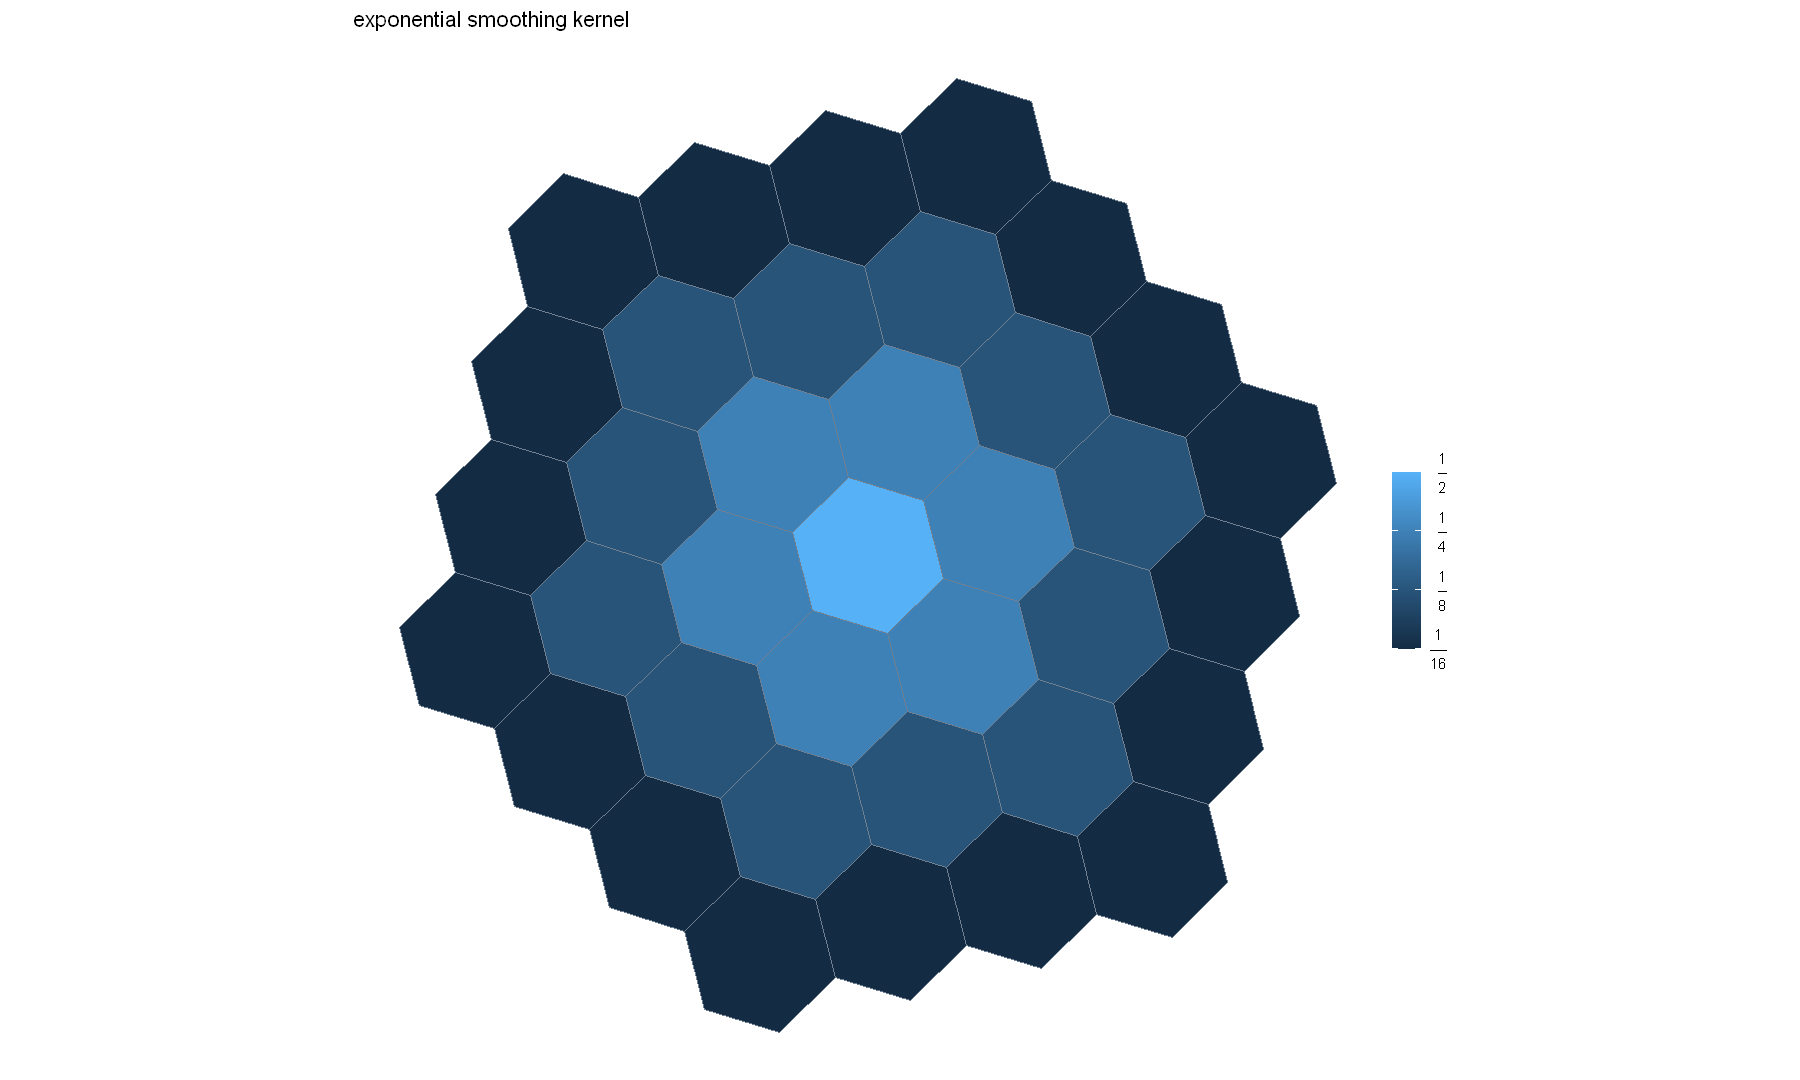

In [34]:
tibble(distance = seq(0, 3L)) |> 
  mutate(factor = 1/2^(distance + 1)) |> 
  mutate(
    hex = map(distance,
                     ~ unlist(get_ring(h3_address = "8b392201a623fff", ring_size = .x)), 
                     hex_var)
  ) |> 
  unnest(hex) |> 
  select(hex, everything()) |> 
  mutate(factor2 = log2(factor))|> 
  h3_to_polygon(simple = FALSE) |> 
  
  ggplot() +
  geom_sf(aes(fill = factor2), size = 0.5, color = "slategrey") +
  # scale_fill_continuous(labels = c("1/16", "1/8", "1,4" ,expression(1/2))) +
  scale_fill_continuous(labels =  unname(latex2exp::TeX(c("\\frac{1}{16}", "\\frac{1}{8}", 
                                                          "\\frac{1}{4}", "\\frac{1}{2}")))) +
  theme_void() +
  theme(plot.title.position = "plot",
        axis.title = element_blank(),
        legend.title = element_blank(),
        legend.key.height = unit(0.75, 'cm')) +
  labs(title = "exponential smoothing kernel")

### 4. The optimization

Our goal is to find those optimal e-scooter parking spots that would minimize the cost function, as described in [3.3 Cost model](#3.3-Cost-model); using a calculation scheme that can be run in feasible timeframe. Mathematically minimum cost solution is very hard to find given the following number of dimensions:

In [35]:
print(paste0("Total hexagons, covering Porto: ", as.character(count(hex_all))))
print(paste0("Total hexagons, representing e-scooter traffic: ", as.character(count(hex_trip))))
print(paste0("Total parking locations: ", as.character(count(hex_parks))))

[1] "Total hexagons, covering Porto: 17633"
[1] "Total hexagons, representing e-scooter traffic: 2253"
[1] "Total parking locations: 210"


We came up with heuristics, a step-wise approach, bringing down cost level by as much as 27%. 

#### 4.1 The step-wise optimization
##### 4.1.1 Step 1. Exclusion of parking spots with high traffic, and adding new parking spots where traffic is high
As seen in EDA, 75% of e-scooter trips end and/or start in designated parkings. They are counted with zero cost due to zero distance to parking. Movement of these parkings would directly increase our overall cost function by the number of trips within these parkings. For this reason, we try to keep them unchanged as much as possible, and only move those ones that contribute to overall cost function with the smallest amounts (having smallest traffic in them). This way we keep 80% of trips already in parkings unchanged.
As a low hanging fruit, we allocate those hexes where traffic is highest, but do not have parkings yet. The top 40% trip volume is covered in this manner.

##### 4.1.2 Step 2. Kernel radius = 1
Hexagonal areas, allocated for parking spots in the previous step, are excluded from this calculation step. We look at the remaining traffic, having non-zero cost contribution.
On each hex, a smoothing kernel is applied with radius = 1. In this manner we embed in the traffic of a given hex, the traffic in all of its direct neighbours too. The smoothing kernel takes care of this weighted average calculation.
The logic behind this step is the following: we model e-scooter users' behavior with this weighted average scheme. Even if a rider started/stopped his/her trip within the boundaries of a given hex, we can still assume this person could have started/stopped his/her trip in neighbouring hexes as well with some lower probability. I.e. if there was a parking place nearby, the person would have been willing to leave the scooter there. This step introduces hex distance cost 1.
We pick the top 20% of these hexes, having the highest weighted average traffic, and assing parking places to them.

##### 4.1.3 Step 3-4 Kernel radius 2 and 3
Basically step 2 is repeated, with increasing smoothing kernels. In each step we consider higher and higher walking distances to nearest parkings, adding 2 and 3 distance costs as well.
Since we want to minimize our cost, we only allow these higher distance parkings when the busiest locations are all covered with 0 or 1 hex distance (Step 1 and 2)

##### 4.1.4 Tuning, optimization
The current code comes with preset parameters, however, in a production environment, the above mentioned % threshold figures would require adjustments. The goal is to cover most of the traffic with 210 stations, while keeping the cost at minimum. This would be an iterative method, that we couldn't implement to run fully automatically within the timreframe of this challenge, hence the manually 'tuned' thresholds.

#### 4.2 The code
##### 4.2.1 Functions
We start with functions for calculating distance, cost and smoothing kernel.

In [36]:
pal <- colorNumeric(palette = "inferno", domain = c(0, 3.5))
hex_trip_plot <- 
  hex_trip |> 
  mutate(log10count = log10(count + 1),
         color = pal(log10count)) |> 
  # mutate(label = paste(count, ":", hex)) |> 
  h3_to_polygon(simple = FALSE)

distance_to_destinations <- function(hex_var, hex_destinations) {
  hex_destinations |> 
    select(hex_park = hex) |> 
    bind_cols(
      hex_distance = grid_distance(rep(hex_var, nrow(hex_destinations)), pull(hex_destinations, hex))
    ) |> 
    as_tibble() 
}

detailed_costs <- function(h3df_trips, h3df_parks) {
  h3df_trips |>
    rename(hex_trip = hex, count_trip = count) |> 
    mutate(data = map(hex_trip, distance_to_destinations, h3df_parks)) |> 
    unnest(data) |> 
    group_by(hex_trip) |> 
    slice_min(n = 1, order_by = hex_distance) |> 
    mutate(count_parks = n()) |> 
    mutate(cost = hex_distance * (count_trip / count_parks)) |> 
    select(hex_trip, hex_park, count_parks, everything()) |> 
    ungroup()
}
  

hex_pareto <- function(hex_count, p_limit) {
  hex_count |> 
    arrange(desc(count)) |> 
    mutate(p = count / sum(count), 
           p_cum = cumsum(p)) |> 
    filter(p_cum <= p_limit)
}

# variable exponential smoothing kernel
kernel_exp2_radius <- function(hex_radius = 1L) {
  
  tibble(distance = seq(0, as.integer(hex_radius))) |> 
    mutate(factor = 1/2^(distance + 1)) |> 
    mutate(hex_count = ifelse(distance == 0, 1, 6 * distance))
  
}

# calculate the hex kernel for 1 hex cell
kernel_hex_cell <- function(hex_var, hex_radius = 1L) {
  
  kernel_exp2_radius(hex_radius = hex_radius) |> 
    mutate(
      hex_kernel = map(distance,
                       ~ unlist(get_ring(h3_address = hex_var, ring_size = .x)), 
                       hex_var)
    ) |> 
    unnest(hex_kernel)
}

# calculate the kernel factor for all hex cells
kernel_smooth <- function(hex_traffic, hex_radius = 1L) {
  
  kernel_factor <- 
    hex_traffic |> 
    mutate(data = map(hex, kernel_hex_cell, hex_radius = hex_radius)) |> 
    unnest(data) |> 
    semi_join(hex_valid, by = c("hex_kernel" = "hex"))
  
  kernel_rescale <- kernel_exp2_radius(hex_radius = hex_radius) |> pull(factor) |> sum()
  
  # summarize after applying the kernel to the count
  kernel_factor <- 
    kernel_factor |>
    group_by(hex_kernel, factor) |>
    summarise(count = sum(count)) |> 
    left_join(kernel_exp2_radius(hex_radius = hex_radius)) |> 
    mutate(count =  count * factor / hex_count) |> 
    summarise(count = sum(count)) |> 
    mutate(count =  count / kernel_rescale) |> 
    rename(hex = hex_kernel)
  
}

hex_valid = hex_all

cost_init = detailed_costs(hex_trip, hex_parks)
total_init <- cost_init |> pull(cost) |> sum()

# Cost is recorded in the report table
steps_summary <- 
  tibble(step = 0, cost = total_init, 
         number_parks = nrow(hex_parks), comment = "current park allocation (6 parks were already removed for close proximity)")

##### 4.2.2 Step 1

In [37]:
# step 1
new_parks <- 
  hex_trip |> 
  semi_join(
    bind_rows(
      hex_trip |> semi_join(hex_parks, by = "hex") |> hex_pareto(0.8),
      hex_trip |> anti_join(hex_parks, by = "hex") |> hex_pareto(0.4)
    ) |> 
      select(hex)
  ) |> 
  mutate(step = 1L)

cost_step1 = detailed_costs(hex_trip, new_parks)
total_step1 <- cost_step1 |> pull(cost) |> sum()

steps_summary <- 
  steps_summary |> 
  bind_rows(tibble(step = 1, cost = total_step1, 
                   number_parks = nrow(new_parks), comment = "80% for existing parks + 40% for outside existing parks"))

Joining, by = "hex"


##### 4.2.3 Step 2

In [38]:
# step 2 
hex_valid <- hex_valid |> anti_join(new_parks)
trip_rest <- hex_trip |> anti_join(new_parks)
trip_smooth <- trip_rest |> kernel_smooth(hex_radius = 1)

new_parks <-
  new_parks |> 
  bind_rows(
    hex_trip |> 
      semi_join(
        trip_smooth |> 
          hex_pareto(0.2) |> 
          select(hex)
    ) |> 
    mutate(step = 2L)
  ) 

cost_step2 = detailed_costs(hex_trip, new_parks)
total_step2 <- cost_step2 |> pull(cost) |> sum()

steps_summary <- 
  steps_summary |> 
  bind_rows(tibble(step = 2, cost = total_step2, 
                   number_parks = nrow(new_parks), comment = "20% - kernel radius = 1"))

Joining, by = "hex"
Joining, by = c("hex", "count")
`summarise()` has grouped output by 'hex_kernel'. You can override using the `.groups` argument.
Joining, by = "factor"
Joining, by = "hex"


##### 4.2.4 Step 3

In [39]:
# step 3 
hex_valid <- hex_valid |> anti_join(new_parks)
trip_rest <- hex_trip |> anti_join(new_parks)
trip_smooth <- trip_rest |> kernel_smooth(hex_radius = 2)

Joining, by = "hex"
Joining, by = c("hex", "count")
`summarise()` has grouped output by 'hex_kernel'. You can override using the `.groups` argument.
Joining, by = "factor"


In [40]:
new_parks <-
  new_parks |> 
  bind_rows(
    hex_trip |> 
      semi_join(
        trip_smooth |> 
          hex_pareto(0.2) |> 
          select(hex)
    ) |> 
    mutate(step = 3L)
  ) 

cost_step3 = detailed_costs(hex_trip, new_parks)
total_step3 <- cost_step3 |> pull(cost) |> sum()

steps_summary <- 
  steps_summary |> 
  bind_rows(tibble(step = 3, cost = total_step3, 
                   number_parks = nrow(new_parks), comment = "20% - kernel radius = 2"))

Joining, by = "hex"


##### 4.2.5 Step 4

In [41]:
# step 4 
hex_valid <- hex_valid |> anti_join(new_parks)
trip_rest <- hex_trip |> anti_join(new_parks)
trip_smooth <- trip_rest |> kernel_smooth(hex_radius = 3)

new_parks <-
  new_parks |> 
  bind_rows(
    hex_trip |> 
      semi_join(
        trip_smooth |> 
          hex_pareto(0.2) |> 
          select(hex)
    ) |> 
	slice_max(count, n = 210 - nrow(new_parks)) |>
    mutate(step = 4L)
  ) 

cost_step4 = detailed_costs(hex_trip, new_parks)
total_step4 <- cost_step4 |> pull(cost) |> sum()

steps_summary <- 
  steps_summary |> 
  bind_rows(tibble(step = 4, cost = total_step4, 
                   number_parks = nrow(new_parks), comment = "20% - kernel radius = 3"))

Joining, by = "hex"
Joining, by = c("hex", "count")
`summarise()` has grouped output by 'hex_kernel'. You can override using the `.groups` argument.
Joining, by = "factor"
Joining, by = "hex"


##### 4.2.6 Results

In [42]:
steps_summary

step cost   number_parks
1 0     42124 210         
2 1    200465  98         
3 2    120482 127         
4 3     61883 168         
5 4     30530 210         
  comment                                                                   
1 current park allocation (6 parks were already removed for close proximity)
2 80% for existing parks + 40% for outside existing parks                   
3 20% - kernel radius = 1                                                   
4 20% - kernel radius = 2                                                   
5 20% - kernel radius = 3

The above table summarizes the total aggregated cost after running each step.
* Our baseline was ~42k with the original 210 stations.
* Step 1 covered 98 stations, they carry 80% of the total traffic with existing parkings, plus the newly assigned top 40% of busiest hexes.
* Step 2 adds another 29 stations, bringing cost down to 120k
* Step 3 adds again 41 stations
* Finally step 3 fills the remaining allowance of 210 stations, with a total aggregated cost of ~30k

Clearly, in accordance with all the assumptions made around using H3 hexagonal mapping, we managed to place e-scooter parking stations 27% closer to the users, most probably resulting in less abandoned e-scooters, at the end of the day.


##### 4.2.7 Further steps
* Such an optimization can be executed at regular time intervals. However, if parking spots are modified over time, 1.) such historical data has to be incorporated into the parking location dataset, 2.) the optimization algorithm will have to take into account the time dimension as well in the cost calculations
* The algorithm execution currently requires manual parameter tuning, which is still a feasible task in even short time; however, fully automated approach could also be developed
* It is likely that there are further limitations when it comes to where parking spots can be placed, or even where they have to be placed (due to local regulations, practicalities, or due the intention of making e-scooters popular at new locations). Such places can be made permanent in the calculations, so that they are not affected.
* Adding GTFS - public transportation data: such data can contribute to the recommended / must have list of parking locations
* We recommend to review proposed new parking locations by experts, and make manual adjustments before work orders are placed. For this purpose we developed the following "dashboard".

##### 4.2.8 The dashboard
Hexes are marked by the followings:
* green: keep the parking station within the area of this hex
* red: discard the existing stations
* blue: build new station somewhere within the boundaries of the hex
* grey: hex with e-scooter traffic, and without parking. Opacity is proportional to the logarithm of traffic.
* Dark dots represent existing stations by their exact GPS coordinates.

Full dashboard can be seen below, however, in the Visualizations section, we highlighted a few interesting spots for further analysis: [From 4.2.8 The dashboard](#From-4.2.8-The-dashboard)

In [51]:
IRdisplay::display_html('<iframe src="http://peter.michaletzky.gitlab.io/dataproj_public/leaflet_final_dashboard.html" 
width=900, height=450></iframe>')

Here you can see the code that produces the dashboard content in HTML format.

In [44]:
result <- 
  hex_trip_plot |> 
  left_join(scooter_parks |> as_tibble() |> select(label, hex), by = c("h3_address" = "hex")) |>
  left_join(new_parks |> rename(count_park = count), by = c("h3_address" = "hex")) |> 

  mutate(todo = case_when(!is.na(label) & !is.na(step)  ~ "KEEP",
                          is.na(label) & !is.na(step)  ~ "NEW",
                          !is.na(label) & is.na(step)  ~ "REMOVE",
                          TRUE ~ NA_character_)) |> 
  
  mutate(color = case_when(todo == "KEEP" ~ "green",
                           todo == "REMOVE" ~ "red",
                           todo == "NEW" ~ "blue",
                           TRUE ~ "grey")) |> 
  
  replace_na(list(label = "")) |> 
  
  mutate(text1 = ifelse(is.na(todo), "", paste0(todo, "<br>"))) |> 
  
  mutate(text = paste0(text1, 
                       "trip count = ", scales::comma(count), "<br>",
                       h3_address, "<br>", 
                       label)) |> 
  mutate(log_trips=log10(count)) |>
  
  as_tibble() |> 
  select(hex = h3_address, todo, color, text, log_trips) |> 
  
  h3_to_polygon(simple = FALSE) 
  
  log_rescale <- max(result$log_trips)

In [45]:
leaflet() |> 
  addTiles(options = tileOptions(opacity = 0.5)) |> 

  addCircles(data = scooter_parks,
             color = "navy", weight = 1, radius = 10, fillColor="navy", fillOpacity=1,
             label = ~ label
             ) |>
  addPolygons(data = result,
                color = "gray", weight = 0.1,
                fillColor = ~ color, fillOpacity = 0.4+result$log_trips/log_rescale*0.6,
                label = map(result$text, htmltools::HTML)) |> 
    
  addLegend(colors=c("green", "red", "blue"), labels=c("keep", "discard", "new"),
    opacity = 0.6
  )  |> 
   addTitle("Proposed E-scooter parking spot changes", "18px") |>
   saveWidget(here::here("submit", "leaflet_final_dashboard.html"))

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

### From 2.1.2 Parkings too close to each other

RSBRA0 and RCAMO0 stations are only 27.5 meters apart.

[Leaflet viewer of parkings too close to each other](http://peter.michaletzky.gitlab.io/dataproj_public/leaflet_parks_too_close.html)

### From 3.4 Smoothing kernel

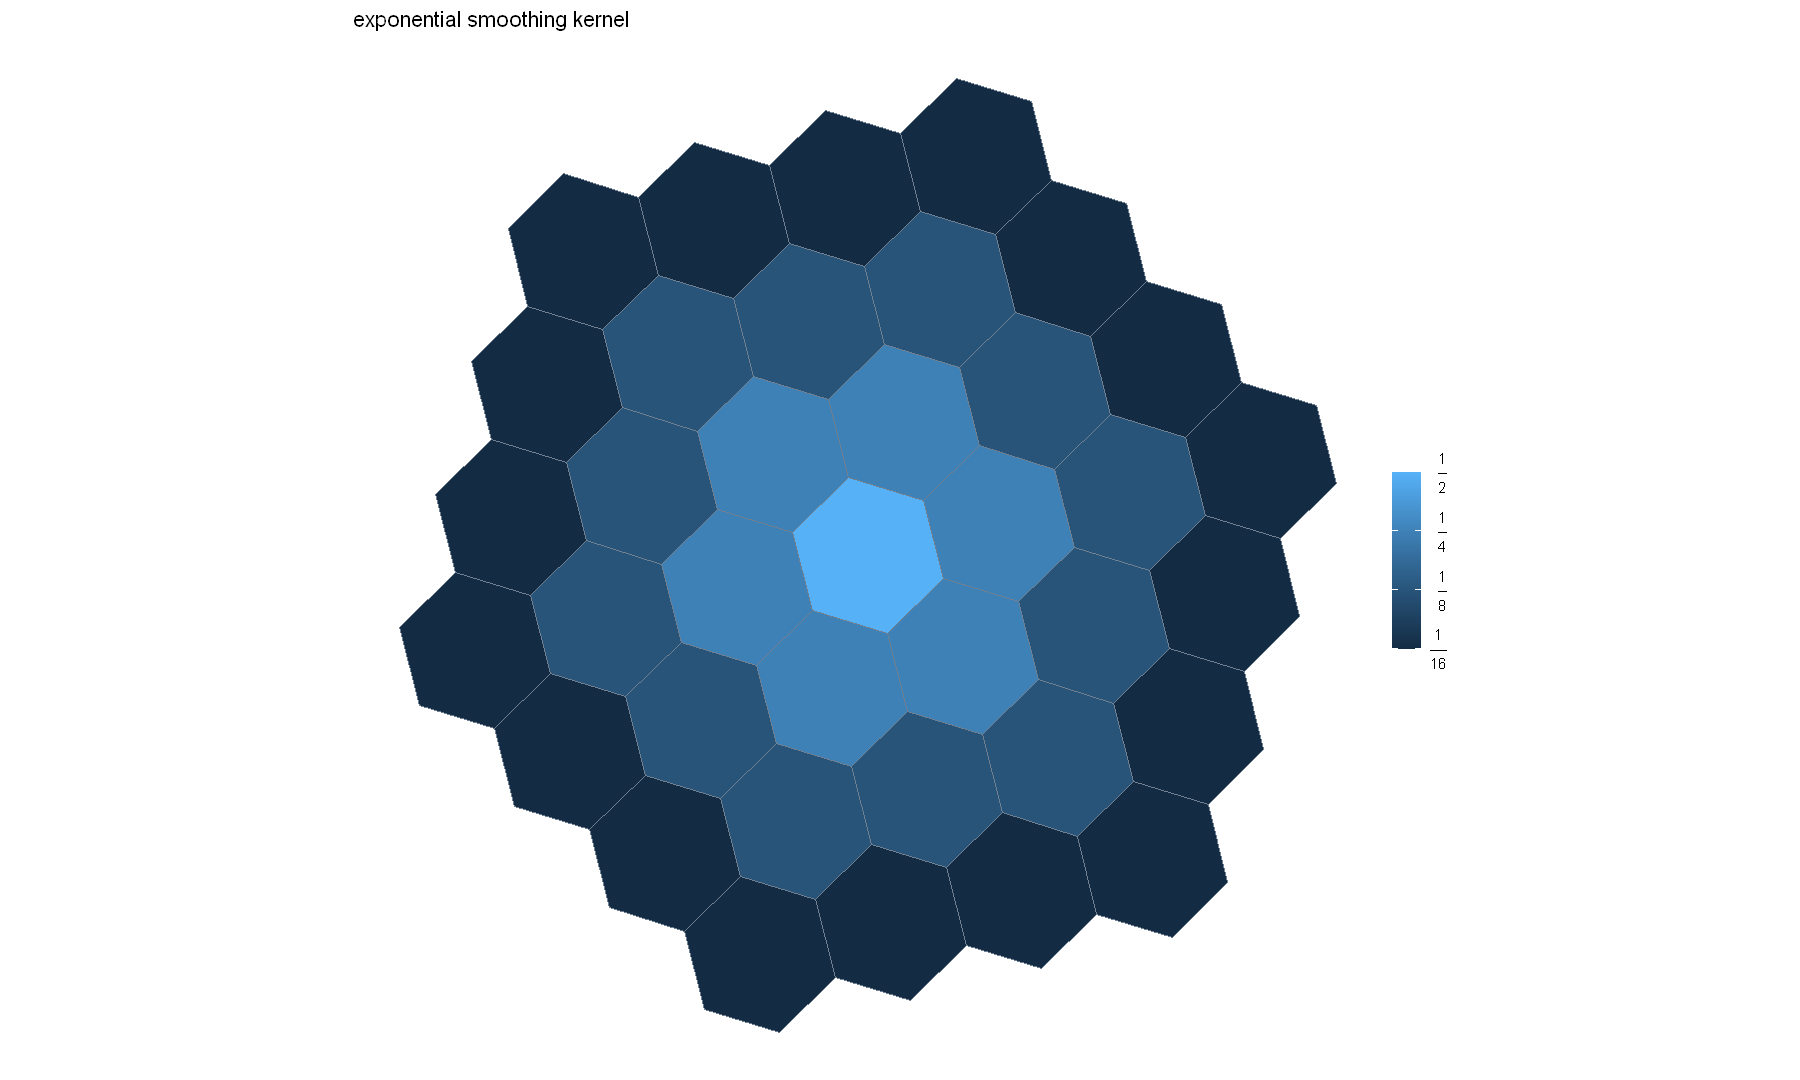

In [46]:
tibble(distance = seq(0, 3L)) |> 
  mutate(factor = 1/2^(distance + 1)) |> 
  mutate(
    hex = map(distance,
                     ~ unlist(get_ring(h3_address = "8b392201a623fff", ring_size = .x)), 
                     hex_var)
  ) |> 
  unnest(hex) |> 
  select(hex, everything()) |> 
  mutate(factor2 = log2(factor))|> 
  h3_to_polygon(simple = FALSE) |> 
  
  ggplot() +
  geom_sf(aes(fill = factor2), size = 0.5, color = "slategrey") +
  # scale_fill_continuous(labels = c("1/16", "1/8", "1,4" ,expression(1/2))) +
  scale_fill_continuous(labels =  unname(latex2exp::TeX(c("\\frac{1}{16}", "\\frac{1}{8}", 
                                                          "\\frac{1}{4}", "\\frac{1}{2}")))) +
  theme_void() +
  theme(plot.title.position = "plot",
        axis.title = element_blank(),
        legend.title = element_blank(),
        legend.key.height = unit(0.75, 'cm')) +
  labs(title = "exponential smoothing kernel")

### From 4.2.8 The dashboard

Data says the area around RAR is somewhat visited by e-scooters, but there are by far less riders there than parking stations. Algorithm proposes to discard the majority of them. There could be political reasons behind keeping them, despite of this data-driven recommendation.


The inner city must be alread very busy with e-scooters, but based on our cost model, it may be worth considering adding more. 


This picture suggests the removal of the spot marked by red, and adding 2 adjacent new locations... We have to see these results with common sense. It looks like the parking place in reality is placed very close to the red hex's border, while traffic is ended/started in the blue hexes, most likely still representing traffic within the parking. This is due to the H3 hex resolution with 43 meters center-center resolution. It could be possible to run the algorithm with higher resolution as well (higher runtime).


It is quite clear that the hex-based calculation scheme is sensitive to parking spots located near the hex borders.



## 👓 References
[Electric scooters in Porto](https://www.porto.pt/en/news/electric-scooters-are-set-to-go-and-ride-through-porto-starting-1st-june)

[E-scooter dataset: Soft-Mobility.zip](https://wdl-data.fra1.digitaloceanspaces.com/porto/Soft-Mobility.zip)

[Leaflet viewer of parkings too close to each other](http://peter.michaletzky.gitlab.io/dataproj_public/leaflet_parks_too_close.html)

[Leaflet viewer of final dashboard](http://peter.michaletzky.gitlab.io/dataproj_public/leaflet_final_dashboard.html)

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.

### A1. Porto border polygon

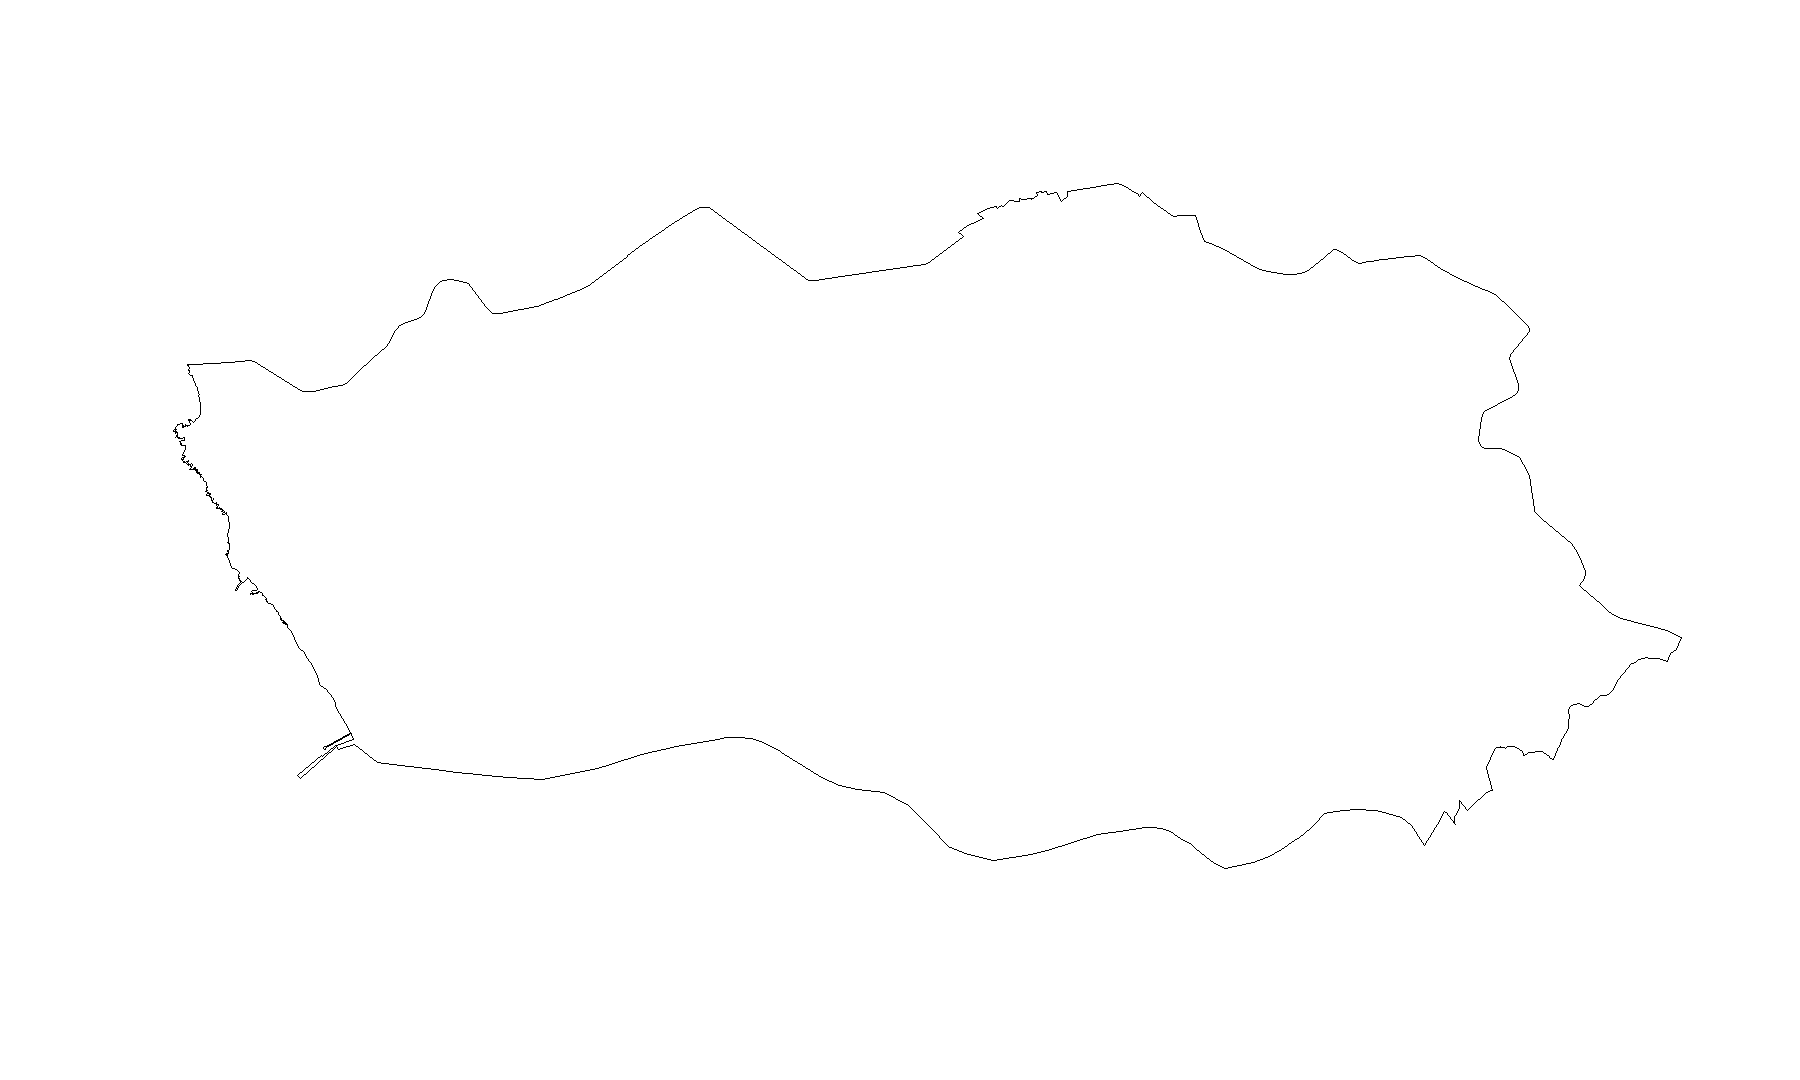

In [47]:
plot(sf_poly_porto)

### A2. E-scooter traffic data - non trip-related data

There is a large amount of `{maintenance_pick_up}` events, unfortunately there is no indication of the real meaning of the coordinates. If this would be position of the park where the scooter is placed after maintenance it can help to deduce the occupancy of the park with free scooters.

In [48]:
wdl_od |> 
  filter(!str_detect(event_types, "trip")) |> 
  count(vehicle_state, event_types, name = "count") |> 
  arrange(vehicle_state, count) 

vehicle_state   event_types                           count
1  available       {unspecified}                            35
2  available       {battery_charged}                       372
3  available       {reservation_cancel}                    403
4  available       {comms_restored}                       1673
5  available       {missing,located}                      6913
6  available       {provider_drop_off}                   22576
7  available       {located}                             40072
8  elsewhere       {unspecified,located}                 80472
9  non_operational {unspecified}                             1
10 non_operational {provider_drop_off,battery_low}         267
11 non_operational {missing,located,battery_low}           941
12 non_operational {comms_restored,battery_low}           1228
13 non_operational {located,battery_low}                  3164
14 non_operational {battery_low}                          4371
15 on_trip         {unspecified}                             1
16 removed         {decommissioned}                        142
17 removed         {unspecified}                           409
18 removed         {maintenance_pick_up}                 89974
19 reserved        {provider_drop_off,reservation_start}     1
20 reserved        {located,reservation_start}              30
21 reserved        {reservation_start}                    1702
22 unknown         {unspecified}                             1
23 unknown         {reservation_cancel,missing}              6
24 unknown         {reservation_cancel,comms_lost}          14
25 unknown         {comms_lost}                          13347
26 unknown         {missing}                             41715

### A3. Porto grid 8

Porto hexagonal grids with resolution of 8.

In [49]:
h3_restable <- 
tibble::tribble(
      ~res,                         ~area,                               ~edge,                   ~unique,
        0L,                  4250546.8477,                         1107.712591,                       122,
        1L,                607220.9782429,                         418.6760055,                       842,
        2L,                 86745.8540347,                         158.2446558,                      5882,
        3L,                 12392.2648621,                         59.81085794,                     41162,
        4L,                  1770.3235517,                          22.6063794,                    288122,
        5L,                   252.9033645,                         8.544408276,                   2016842,
        6L,                    36.1290521,                         3.229482772,                  14117882,
        7L,                     5.1612932,                         1.220629759,                  98825162,
        8L,                     0.7373276,                         0.461354684,                 691776122,
        9L,                     0.1053325,                         0.174375668,                4842432842,
       10L,                     0.0150475,                         0.065907807,               33897029882,
       11L,                     0.0021496,                         0.024910561,              237279209162,
       12L,                     0.0003071,                         0.009415526,             1660954464122,
       13L,                      4.39e-05,                         0.003559893,            11626681248842,
       14L,                       6.3e-06,                         0.001348575,            81386768741882,
       15L,                         9e-07,                         0.000509713,           569707381193162
  )

h3_selected <- h3_restable |> 
  mutate(area = area * 1e6,
         edge = edge *1e3) |> 
  filter(between(res, 7, 11)) |> 
  select(-unique) |> 
  mutate(center_distance = sqrt(3) * edge)

trip_start <- 
  trip_start_stop |> 
  st_as_sf(coords = c("lng_start", "lat_start"), crs = 4326) 

trip_end <- 
  trip_start_stop |> 
  st_as_sf(coords = c("lng_end", "lat_end"), crs = 4326) 

count_hex_porto <- function(res) {
  polyfill(sf_poly_porto, res = res) |> unlist() |> length()  
}

count_hex_point <- function(res, sf) {
  sf |> 
    point_to_h3(res = res) |> 
    unique() |> 
    length() 
}

hex_summary <- 
  h3_selected |> 
  mutate(porto_hex =  map_int(res, count_hex_porto)) |> 
  mutate(park_hex = map_int(res, count_hex_point, scooter_parks)) |> 
  mutate(start_hex = map_int(res, count_hex_point, trip_start)) |> 
  mutate(end_hex = map_int(res, count_hex_point, trip_end))


hex_porto_8 <- 
  tibble(hex = polyfill(sf_poly_porto, res = 9) |> unlist()) |> 
  mutate(res = 9) |> 
  h3_to_polygon(simple = FALSE) 

ggplot() +
  geom_sf(data = sf_poly_porto, alpha = 0.2, color = "lightslategray", linetype = "dashed", size = 1) +
  geom_sf(data = hex_porto_8,
          shape = 19, size = 0.5, color = "darkgreen", alpha = 0.2) +
  theme_bw() +
  theme(plot.title.position = "plot",
        axis.title = element_blank()) +
  labs(title = "Porto - h3 grid",
       subtitle = "resolutions = 8")
